# Import module

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import re

import xgboost as xgb
import numpy as np
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score
import joblib

import warnings
warnings.filterwarnings('ignore')

# Data loading

First, I will load the dataset, which includes two features: timepoint (measured in hours) and temperature. Additionally, there is one dependent variable, representing the total number of bicyclists riding through Coupure Links street over the course of an hour. The dataset spans 6 months, from January 2023 to June 2023.

Given the limited number of features, it is essential to enhance the number of features, which aims to help model with for better extracting important information.

I believe that weather and holidays can significantly impact the number of bicyclists. Therefore, I plan to include weather data for Coupure Links street, sourced from Open Meteo, to ensure a more comprehensive analysis.


Furthermore, I will extract additional elements from the timepoint feature, including month, day, hour, day of the week, weekday, and weekend. This involves breaking down the timepoint into smaller elements, facilitating more in-depth downstream analysis during the data exploration phase. Moreover, these extracted elements are expected to assist the model in learning more effectively.

## 1. Training data

In [2]:
# loading the train data
df_data_train = pd.read_csv("./data/train_data.csv")

In [3]:
# change column name
df_data_train.columns = ['date_hour','total']

In [4]:
# After loading the features, the format of time features string. Hence I want to convert string into time type
df_data_train['date_hour'] = pd.to_datetime(df_data_train['date_hour'], format = '%Y-%m-%dT%H')

# Similarly, I want to ensure the type of total feature is integer.
df_data_train['total'] = df_data_train['total'].astype(int)

# display first 5 rows
df_data_train.head()

,date_hour,total
0,2023-01-01 00:00:00,111
1,2023-01-01 01:00:00,201
2,2023-01-01 02:00:00,170
3,2023-01-01 03:00:00,144
4,2023-01-01 04:00:00,155


In [5]:
# check type of data, ensure the type of date_hour is datetime and type of total is integer 
df_data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4343 entries, 0 to 4342
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date_hour  4343 non-null   datetime64[ns]
 1   total      4343 non-null   int32         
dtypes: datetime64[ns](1), int32(1)
memory usage: 51.0 KB


In [6]:
# generate more information based on date_hour feature (split into month, date, hour, day of week). 
df_data_train['date'] = df_data_train['date_hour'].dt.date
df_data_train['month'] = df_data_train['date_hour'].dt.month
df_data_train['day'] = df_data_train['date_hour'].dt.day
# because the whole train dataset in 2023, it is not necessary to extract the year feature. (year is the same for the whole dataset) 
# If we have a longer historical data, which contain more than 2,3 years, year feature might have a great impact on reponse
df_data_train['hour'] = df_data_train['date_hour'].dt.hour
df_data_train['day_of_week'] = df_data_train['date_hour'].dt.day_of_week
df_data_train['day_of_week_name'] = df_data_train['date_hour'].dt.day_name()
df_data_train["is_weekend"] = df_data_train['day_of_week_name'].apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)

## 2. Weather data

I downloaded the weather data from Open Meteo, and this dataset contains numerous features. Loading all of these features is not advisable, as not all of them may significantly affect the number of cyclists. Adding more features without contributing valuable information could potentially decrease the model's performance. Therefore, I will manually select the features that I believe could have a substantial impact on the prediction task.

This the description of selected features. Data description is took from Open Meteo website.

- 'time': time (by hour)
- 'temperature_2m (°C)': Air temperature at 2 meters above ground
- 'relativehumidity_2m (%)': 	Relative humidity at 2 meters above ground, a measure of how much water vapor is in a water-air mixture compared to the maximum amount possible
- 'dewpoint_2m (°C)': Dew point temperature at 2 meters above ground,  the temperature the air needs to be cooled to (at constant pressure) in order to achieve a relative humidity (RH) of 100%
- 'apparent_temperature (°C)': 	Apparent temperature is the perceived feels-like temperature combining wind chill factor, relative humidity and solar radiation, the temperature equivalent perceived by humans
- 'precipitation (mm)': can remove
- 'rain (mm)': Rain from large scale weather systems of the preceding hour in millimeter
- 'snowfall (cm)': 	Snowfall amount of the preceding hour in centimeters. For the water equivalent in millimeter, divide by 7. E.g. 7 cm snow = 10 mm precipitation water equivalent
- 'snow_depth (m)':  Snow depth on the ground
- 'weathercode (wmo code)': Weather condition as a numeric code. Follow WMO weather interpretation codes. See table below for details.
- 'windspeed_10m (km/h)': Wind speed at 10, 80, 120 or 180 meters above ground. Wind speed on 10 meters is the standard level.
- 'windgusts_10m (km/h)': Gusts at 10 meters above ground as a maximum of the preceding hour
- 'is_day ()': 1 if the current time step has daylight, 0 at night.
- 'direct_radiation (W/m²)': Direct solar radiation as average of the preceding hour on the horizontal plane and the normal plane (perpendicular to the sun)


In [7]:
# load the weather data and convert the string format of time into time format
df_data_weather = pd.read_csv("./data/weather_full.csv", skiprows=2) # the data start at the 2nd row
df_data_weather['date_hour'] = pd.to_datetime(df_data_weather['time'], format = '%Y-%m-%dT%H:%M')
df_data_weather.drop('time',axis=1, inplace=True)

In [8]:
# select features that may contain valuable information for training model
weather_selected_features = ['date_hour','temperature_2m (°C)', 'relativehumidity_2m (%)',
       'dewpoint_2m (°C)', 'apparent_temperature (°C)', 'precipitation (mm)',
       'rain (mm)', 'snowfall (cm)', 'snow_depth (m)',
       'weathercode (wmo code)',
       'windspeed_10m (km/h)', 'windspeed_100m (km/h)',
       'windgusts_10m (km/h)', 'is_day ()',
       'shortwave_radiation (W/m²)', 'direct_radiation (W/m²)']
# choose feature for weather
df_data_weather = df_data_weather[weather_selected_features]

In [9]:
# change column name of weather data
df_data_weather.columns = [x.split(' ')[0] for x in df_data_weather.columns]

In [10]:
# Extarct the span time of weather feature. I will use the time span is from Jan 2023 to Jun 2023 for training dataset
# and July 2023 for testing
df_data_weather = df_data_weather[(df_data_weather['date_hour'] >= '2023-01-01') & (df_data_weather['date_hour'] < '2023-08-01')]

In [11]:
# display five first rows of data
df_data_weather.head()

,date_hour,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,rain,snowfall,snow_depth,weathercode,windspeed_10m,windspeed_100m,windgusts_10m,is_day,shortwave_radiation,direct_radiation
48,2023-01-01 00:00:00,15.9,50,5.4,9.4,0.0,0.0,0.0,0.0,3,36.9,58.8,68.0,0,0.0,0.0
49,2023-01-01 01:00:00,15.3,54,6.1,9.0,0.0,0.0,0.0,0.0,3,37.0,58.9,67.7,0,0.0,0.0
50,2023-01-01 02:00:00,14.8,59,6.9,8.8,0.0,0.0,0.0,0.0,2,35.5,56.4,64.1,0,0.0,0.0
51,2023-01-01 03:00:00,14.3,65,7.7,9.1,0.0,0.0,0.0,0.0,3,32.1,51.2,62.6,0,0.0,0.0
52,2023-01-01 04:00:00,13.9,68,8.0,9.4,0.0,0.0,0.0,0.0,2,27.5,44.8,61.2,0,0.0,0.0


In this dataset, weather is encoded, making it challenging to interpret. Therefore, I will decode these numbers into meaningful text. 

The source for decoding: "https://open-meteo.com/en/docs"

In [12]:
# generate dictionary for weather code
wmo_dict = {0: 'clear sky',
            1: 'mainly clear', 
            2: 'partly cloudy',
            3: 'overcast',
            45: 'fog', 
            48: 'depositing rime fog',
            51: 'light intensity - drizzle', 
            53: 'moderate intensity - drizzle',
            55: 'dense intensity - drizzle',
            56: 'light intesity - freezing drizzle',
            57: 'dense intesity - freezing drizzle',
            61: 'slight intensity - rain',
            63: 'moderate intensity - rain',
            65: 'heavy intensity - rain',
            66: 'light intensity - freezing rain',
            67: 'heavy intensity - freezing rain',
            71: 'slight intensity - snow fall',
            73: 'moderate intensity - snow fall',
            75: 'heavy intensity - snow fall',
            77: 'snow grains',
            80: 'slight - rain showers',
            81: 'moderate - rain showers',
            82: 'violent - rain showers',
            85: 'slight - snow showers',
            86: 'heavy - snow showers',
            95: 'slight Thunderstorm: slight or moderate',
            96: 'thunderstorm with slight hail',
            99: 'thunderstorm with heavy hail'
           }

# procesisng weather code => encode and hot encoding
df_data_weather['wmo_encode'] = df_data_weather['weathercode'].map(wmo_dict)
df_data_weather.drop('weathercode',axis=1, inplace=True)

## 3. Holiday data

Holiday features might be associated with the number of bicyclists. When there is a national holiday, people's behavior tends to change; they might go home to visit family or take a vacation elsewhere. 

Furthermore, the Coupure Links street, where the number of bicyclists is measured, is located near the Bioscience Engineering campus of UGent. Therefore, I will include Ghent University holidays, including recess, in the analysis. My assumption is that the number of students riding bicycles to the university significantly contributes to the total count of bicyclists. If there is a holiday or recess, there may be reduced demand for cycling to that site. The examination period of Ugent feature is also considered.

In [13]:
def national_holiday(row):
    """
    Convert date to national holiday
    """
    if row == '2023-01-01':
        return 'New Year"s Day'
    if row == '2023-04-10':
        return "Easter Monday"
    if row == "2023-05-01":
        return "Labour Day"
    if row in ("2023-05-18","2023-05-19"):
        return "Ascension Day"
    if row == "2023-05-29":
        return "Whit Monday"
    if row == "2023-07-11":
        return "Feast of the Flemish Community"
    if row == "2023-07-21":
        return "National Day"
    return "Normal"

def ghent_university_holiday(row):
    """
    Convert date to Ugent holiday
    """
    if "2022-12-26" <= row <="2023-01-07":
        return "Chirstmas recess"
    if "2023-02-06" <= row <= "2023-02-11":
        return "Inter-term recess"
    if row == "2023-03-24":
        return "Dies Natalis"
    if "2023-04-03" <= row <= "2023-04-15":
        return "Easter Recess"
    if row == "2023-05-01":
        return "Labour Day"
    if row in ("2023-05-18","2023-05-19"):
        return "Ascension Day"
    if row == "2023-05-29":
        return "Whit Monday"
    if row == "2023-07-11":
        return "Feast of the Flemish Community"
    if "2023-07-10" <= row <= "2023-08-19":
        return "Summer Recess"
    return "Normal"

def ghent_university_examination_period(row):
    """
    Check if the date is in Ugent examination
    """
    if ('2023-02-04' <= row <= '2023-02-03') or  "2023-05-30" <= row <= "2023-07-07":
        return 1
    else:
        return 0

In [14]:
# similar to the weather data, the time span of dataset will be from Jan 2023 to Jun 2023 for training , and July for test
# In those dataset, I include the July data and will remove it from training dataset later

# start date of holiday data
start = "2022-01-01"
# end date of holidya data
end = "2023-07-31"

# generate date data in specific period of time
datedim = pd.DataFrame(pd.date_range(start=start,end=end).strftime("%Y-%m-%d"), columns=['date'])

# extract features
datedim['national_day'] = datedim['date'].astype(str).apply(national_holiday)
datedim['is_national_day'] = datedim['national_day'].apply(lambda x: 1 if x!='Normal' else 0)
datedim['ugent_holiday'] = datedim['date'].astype(str).apply(ghent_university_holiday)
datedim['is_ugent_holiday'] = datedim['ugent_holiday'].apply(lambda x: 1 if x!='Normal' else 0)
datedim['is_exam_period'] = datedim['date'].astype(str).apply(ghent_university_examination_period)

datedim['date'] = pd.to_datetime(datedim['date'], format='%Y-%m-%d').dt.date 

# Data quality

Before splitting the train data into the training dataset and evaluation dataset, I will check the data quality to ensure there are no artifacts in our training data that might negatively affect the model.

## Check data quality of train data:

In [15]:
# no missing value
df_data_train.isna().any()

date_hour           False
total               False
date                False
month               False
day                 False
hour                False
day_of_week         False
day_of_week_name    False
is_weekend          False
dtype: bool

In [16]:
# no duplicate data
df_data_train['date_hour'].value_counts()

date_hour
2023-01-01 00:00:00    1
2023-05-01 22:00:00    1
2023-05-01 08:00:00    1
2023-05-01 09:00:00    1
2023-05-01 10:00:00    1
                      ..
2023-03-02 13:00:00    1
2023-03-02 14:00:00    1
2023-03-02 15:00:00    1
2023-03-02 16:00:00    1
2023-06-30 23:00:00    1
Name: count, Length: 4343, dtype: int64

In [17]:
# March is missing one date
df_data_train.groupby(df_data_train['month'])['date_hour'].count()

month
1    744
2    672
3    743
4    720
5    744
6    720
Name: date_hour, dtype: int64

In [18]:
# only 2023-03-26 is missing 1 data at 2 am => Because I don't plan to create lagging data, I can ignore this issue
df_data_train['date'].value_counts()

date
2023-01-01    24
2023-04-25    24
2023-04-27    24
2023-04-28    24
2023-04-29    24
              ..
2023-03-05    24
2023-03-06    24
2023-03-07    24
2023-06-30    24
2023-03-26    23
Name: count, Length: 181, dtype: int64

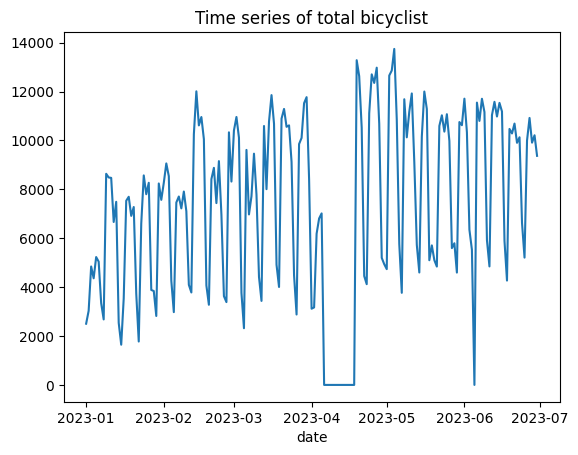

In [19]:
# plot the line graph of total bicyclist vs date. 
df_data_train.groupby(['date'])['total'].sum().plot()
plt.title("Time series of total bicyclist")
plt.show()

There are some days in which the total number of bicycles is recorded as 0, which appears to be not logical. I strongly suspect this is a data recording error.
These data points have the potential to adversely impact both training and evaluation results. Therefore, I prefer to exclude these data points.
In the future, I will focus on enhancing the visual appeal of the plots.

In [20]:
df_group_date = df_data_train.groupby(['date'])['total'].sum().reset_index()
# remove error data
list_date_error = df_group_date[df_group_date['total']==0]['date'].to_list()
df_data_train_clean = df_data_train[~df_data_train['date'].isin(list_date_error)]

## Check data quality of weather data

In [21]:
# no missing value
df_data_weather.isna().any()

date_hour               False
temperature_2m          False
relativehumidity_2m     False
dewpoint_2m             False
apparent_temperature    False
precipitation           False
rain                    False
snowfall                False
snow_depth              False
windspeed_10m           False
windspeed_100m          False
windgusts_10m           False
is_day                  False
shortwave_radiation     False
direct_radiation        False
wmo_encode              False
dtype: bool

In [22]:
# summarize the data => data is in the suitable range (for example snowfall and snow depth cannot be negative)
df_data_weather.drop('date_hour', axis=1).describe() 

,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,rain,snowfall,snow_depth,windspeed_10m,windspeed_100m,windgusts_10m,is_day,shortwave_radiation,direct_radiation
count,5088.000000,5088.000000,5088.000000,5088.000000,5088.000000,5088.000000,5088.000000,5088.000000,5088.000000,5088.000000,5088.000000,5088.000000,5088.000000,5088.00000
mean,11.379756,76.650354,7.036714,8.789544,0.095637,0.094006,0.001142,0.000206,14.433962,23.917708,28.297602,0.552280,150.794025,89.18180
std,6.664281,14.879511,5.183643,7.871632,0.339585,0.336685,0.030403,0.002424,6.503612,10.032433,13.017794,0.497308,219.717093,162.97833
min,-3.800000,28.000000,-6.700000,-7.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.400000,1.400000,0.000000,0.000000,0.00000
25%,6.600000,67.000000,3.500000,2.900000,0.000000,0.000000,0.000000,0.000000,9.700000,17.300000,18.400000,0.000000,0.000000,0.00000
50%,10.600000,80.000000,7.200000,7.350000,0.000000,0.000000,0.000000,0.000000,13.900000,23.300000,27.000000,1.000000,20.000000,1.00000
75%,16.400000,88.000000,10.900000,14.925000,0.000000,0.000000,0.000000,0.000000,18.300000,29.700000,36.400000,1.000000,242.000000,99.00000
max,29.900000,100.000000,19.800000,33.400000,7.700000,7.700000,1.190000,0.040000,39.200000,62.400000,77.400000,1.000000,886.000000,754.00000


# Join dataset

Presently, I possess three distinct datasets: the training data, weather data, and holiday data. It is imperative to consolidate these three datasets into a unified dataset suitable for both training and evaluation purposes.

It's essential to note that, due to the utilization of an inner join, the timeframe of the final dataset will span from January 2023 to June 2023, excluding July. The data from July will be specifically reserved for testing purposes.

In [23]:
# merge train dataset with weather dataset. Again, the time span is from Jan 2023 to Jun 2023
df_merge = df_data_train_clean.merge(df_data_weather, how='inner', on="date_hour")
# merge with holiday dataset. The final data contain features of 3 dataset.
df_merge = df_merge.merge(datedim, how='inner', on='date')
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4007 entries, 0 to 4006
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date_hour             4007 non-null   datetime64[ns]
 1   total                 4007 non-null   int32         
 2   date                  4007 non-null   object        
 3   month                 4007 non-null   int32         
 4   day                   4007 non-null   int32         
 5   hour                  4007 non-null   int32         
 6   day_of_week           4007 non-null   int32         
 7   day_of_week_name      4007 non-null   object        
 8   is_weekend            4007 non-null   int64         
 9   temperature_2m        4007 non-null   float64       
 10  relativehumidity_2m   4007 non-null   int64         
 11  dewpoint_2m           4007 non-null   float64       
 12  apparent_temperature  4007 non-null   float64       
 13  precipitation     

# Split validation set and train set

Before doing Exploratory Data Analysis (EDA) and training the model, I will split the data into train set and validation set. The goal of this validation set is for evaluating the performance, based on that, I can increase the performance of model.

In practice, the timeframe, including holidays, summer, winter, etc., plays a substantial role in shaping bicycle usage patterns. For instance, during extended holidays, the bicycle count tends to experience a significant decline due to a decrease in the number of students commuting to school, particularly at UGent. Typically, the number of holidays is considerably fewer than the number of working or studying days, and holidays often concentrate on specific periods of the year.

If I were to use stratified splitting to divide the validation and training sets, the sheer volume of working/studying days would overshadow the number of holidays. This might cause the model to primarily learn behaviors associated with non-holiday events, potentially resulting in high accuracy but poor performance when predicting bicycle counts during extended holiday periods. Consequently, a more thoughtful approach is needed to ensure the model adequately captures the dynamics of both holiday and non-holiday scenarios. 

Instead of opting for stratified splitting (similar to the way test and train data is spliting), the validation duration should encompass more or less equal the number of holiday and normal events, allowing for an evaluation of the model's performance across diverse events. Hence, I will choose the period from "2023-03-20"  to "2023-04-05" for evaluation dataset (which account for 10% of data. The rest will be used for training

In [24]:
# I will choose  2023-03-20 => 2023-04-05 as dataset (~10%)
validation_start = '2023-03-20'
validation_end = '2023-04-05'
# split the dataset into validation dataset and training dataset
validation_data = df_merge[(df_merge['date'].astype(str)>=validation_start)&(df_merge['date'].astype(str)<=validation_end)]
train_data = df_merge[(df_merge['date'].astype(str)<validation_start)|(df_merge['date'].astype(str)>validation_end)]

In [25]:
validation_data.shape

(407, 29)

In [26]:
train_data.shape

(3600, 29)

# EDA

In this phase, the objective is to analyze and visualize datasets, summarizing their essential characteristics. Through exploration, I aim to uncover patterns, relationships, anomalies, and insights within the data, establishing a solid foundation for subsequent analysis and modeling.

Given that continuous and categorical features necessitate distinct visualization approaches, I will assign the names of continuous and categorical features in advance. This strategic preparation ensures the application of appropriate techniques tailored to each type of feature during the exploratory data analysis process.

In [27]:
# assign target
target_feature = ['total']

# assign continous features and catgegorical features
continous_features = ['temperature_2m','relativehumidity_2m', 'dewpoint_2m', 'apparent_temperature',
                       'precipitation', 'rain', 'snow_depth', 
                       'windspeed_10m', 'windspeed_100m', 'windgusts_10m',
                       'shortwave_radiation', 'direct_radiation', 'snowfall']
categorical_features = ['is_day', 'day_of_week', 'is_weekend', 'wmo_encode', 'month',
                        'is_national_day', 'is_ugent_holiday', 
                        'is_exam_period','day', 'hour']

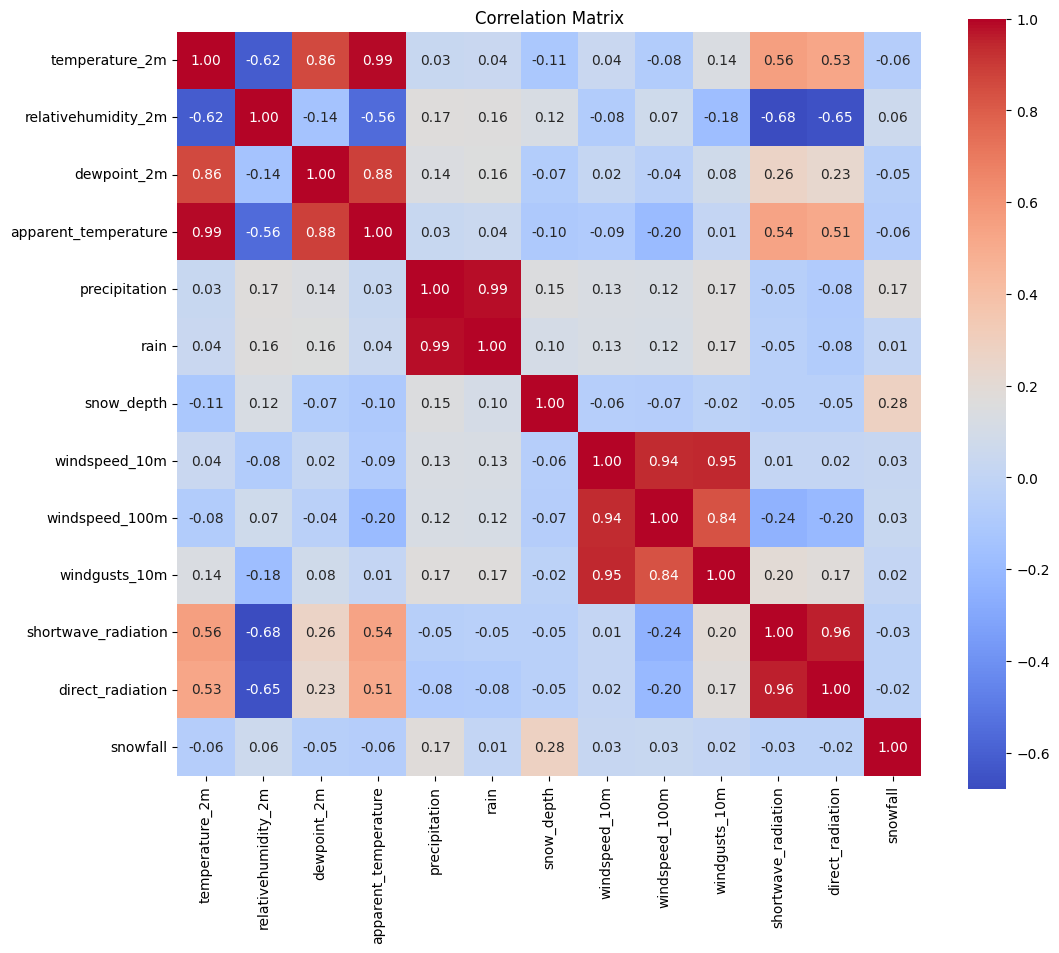

In [28]:
# correlation matrix
correlation_matrix = train_data[continous_features].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Matrix")
plt.show()

Observing the correlation matrix provided, it becomes evident that numerous pairs of features exhibit a high correlation. This indicates that these pairs may contain similar information.

The removal of high correlation is warranted due to several reasons. Firstly, highly correlated features often fail to contribute significantly more information to the model, yet their inclusion increases the complexity of training, potentially leading to overfitting. This addition of unnecessary features may also violate the assumption of independence between the features in certain machine learning algorithms. Moreover, the elimination of high correlation serves to mitigate multicollinearity, particularly in regression models. Addressing multicollinearity ensures a more stable and interpretable model by minimizing the interdependence among predictor variables.

Instead of opting for a random selection of features to eliminate from these highly correlated pairs, I will take a manual approach. I will personally choose the features to be dropped, retaining those that I believe hold more meaningful and interpretable significance for predicting the number of bicyclists. This targeted selection aims to preserve the most informative aspects of the data while ensuring a more insightful and accurate model. 

In [29]:
# Drop high correlated fetaures
drop_features = ['temperature_2m','dewpoint_2m','precipitation',
                 'windspeed_100m', 'windgusts_10m', 'shortwave_radiation'] 
train_data.drop(drop_features, axis=1, inplace=True)
continous_features = list(set(continous_features) - set(drop_features))

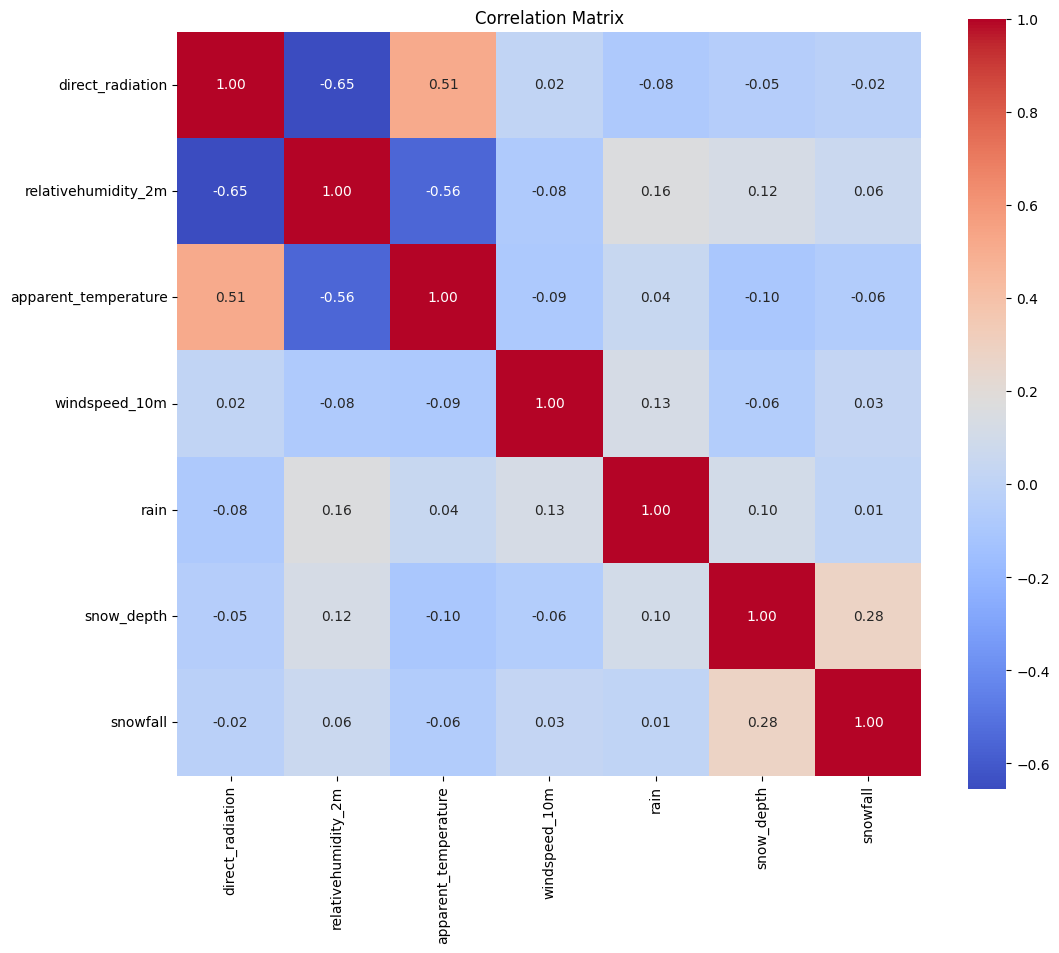

In [30]:
# replot the correlation matrix for checking
correlation_matrix = train_data[continous_features].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Matrix")
plt.show()

In [31]:
# convert categorical features type to category for visualization and training model
train_data[categorical_features] = train_data[categorical_features].astype('category')

Plotting histograms to examine the distribution of each feature. 

It is notable that the majority of values for snow and rain are 0, indicating that occurrences of snow and rain are infrequent events.

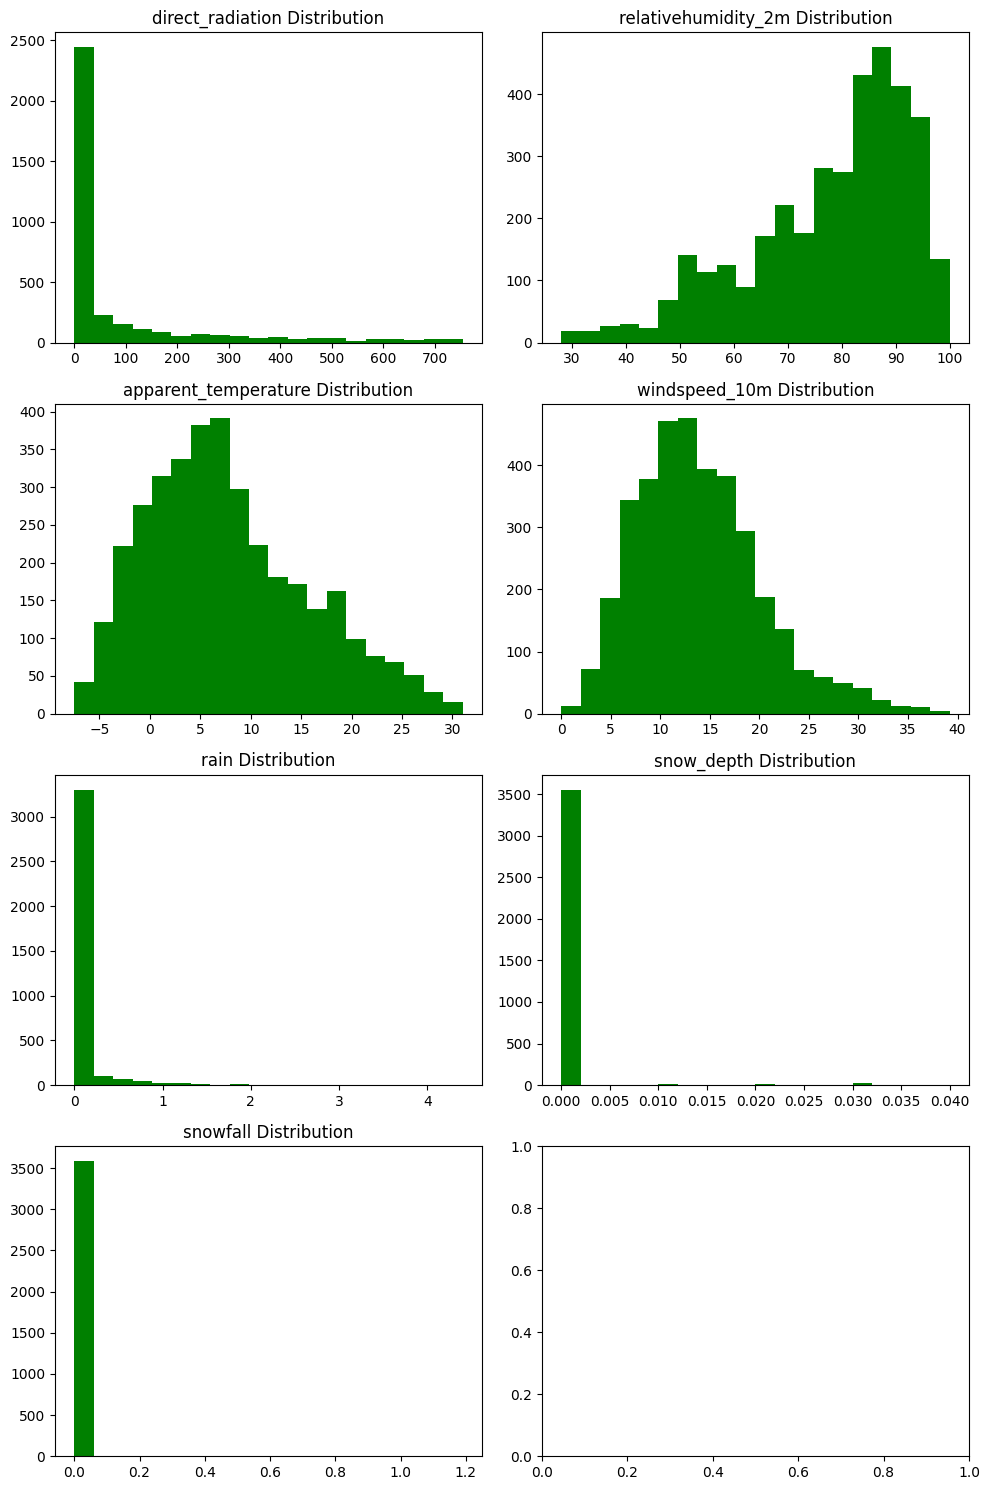

In [32]:
# create a 3 x 3 grid of subplots 
fig, axs = plt.subplots(4,2, figsize = (10,15))

# flatten array to make easier to access each subplot
axs = axs.ravel()

# loop over each column in the dataframe and plot a histogram
for i,column in enumerate(continous_features):
    axs[i].hist(train_data[column], bins = 20, color='green')
    axs[i].set_title('{} Distribution'.format(column))
    
plt.subplots_adjust(hspace=0.5)
plt.tight_layout()
plt.show()

I create scatter plots to assess the correlation between features and the response variable. 

The visualization reveals that a significant portion of features is indeed associated with the response. Notably, the number of bikes tends to decrease during rain or snow events, illustrating a clear correlation.

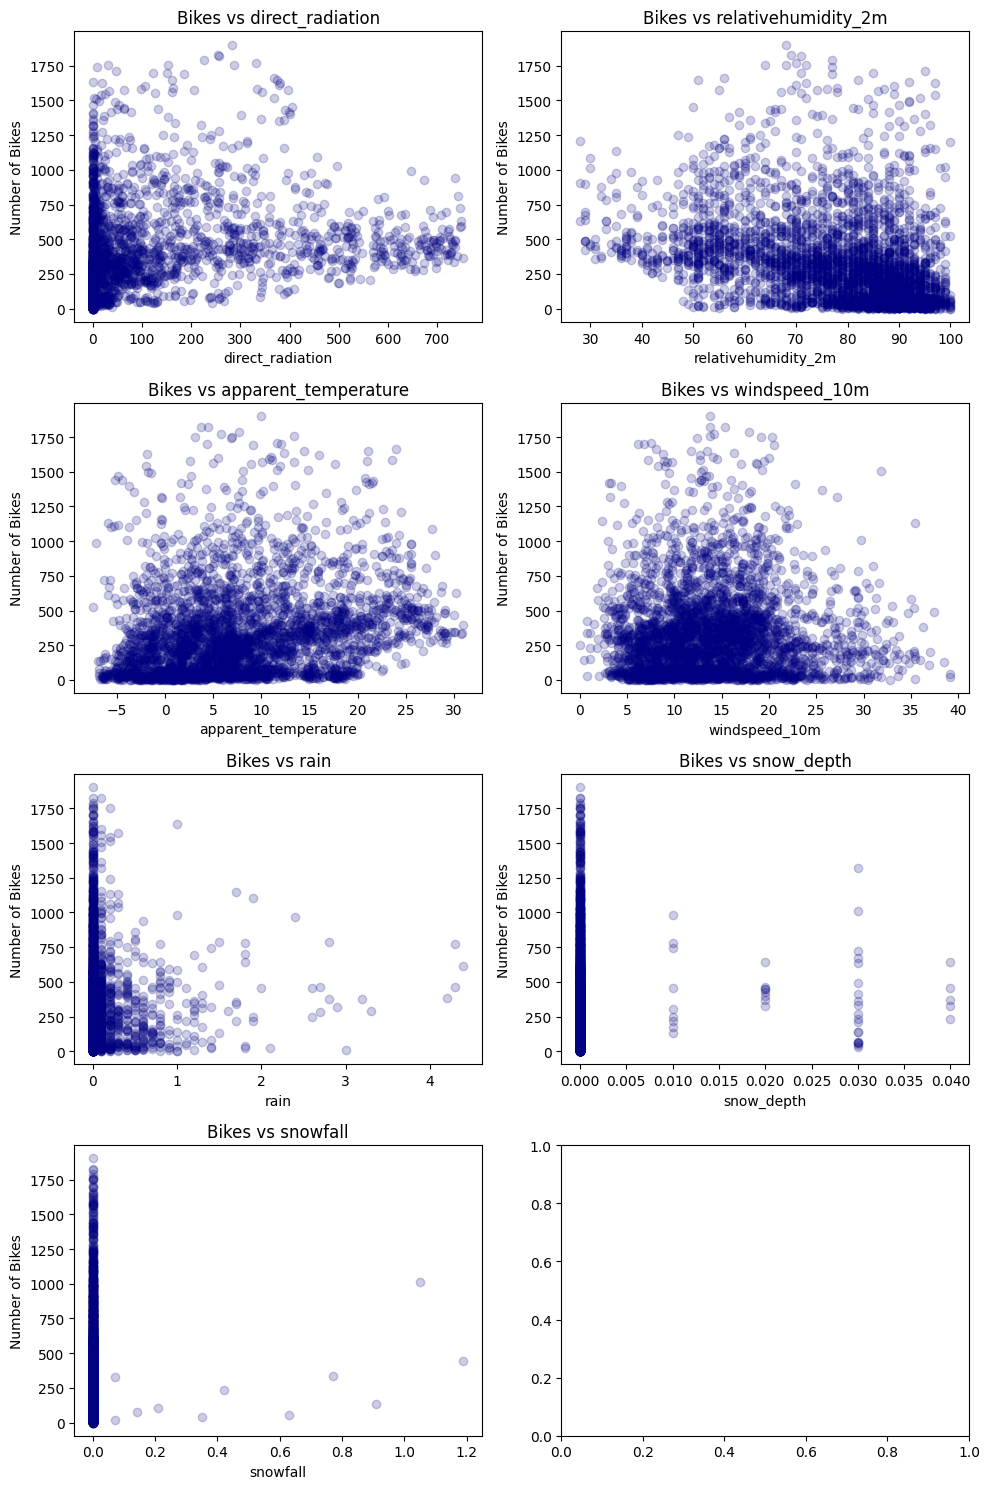

In [33]:
# create a 3 x 3 grid of subplots 
fig, axs = plt.subplots(4,2, figsize = (10,15))

# flatten array to make easier to access each subplot
axs = axs.ravel()

# loop over each column in the dataframe and plot a histogram
for i,column in enumerate(continous_features):
    axs[i].scatter(train_data[column], train_data["total"], alpha = 0.2, color='navy')
    axs[i].set_xlabel(column)
    axs[i].set_ylabel("Number of Bikes")
    axs[i].set_title('Bikes vs {}'.format(column))
    
plt.subplots_adjust(hspace=0.5)
plt.tight_layout()
plt.show()

In order to check the assocation between categorical features and response, I use the boxplot. The boxplot show that those categorical contain many information that can help to predict number of bicyclist. For example, we can see clearly that there is a difference in the distirbution of number of bicyclist in daytime and night. 

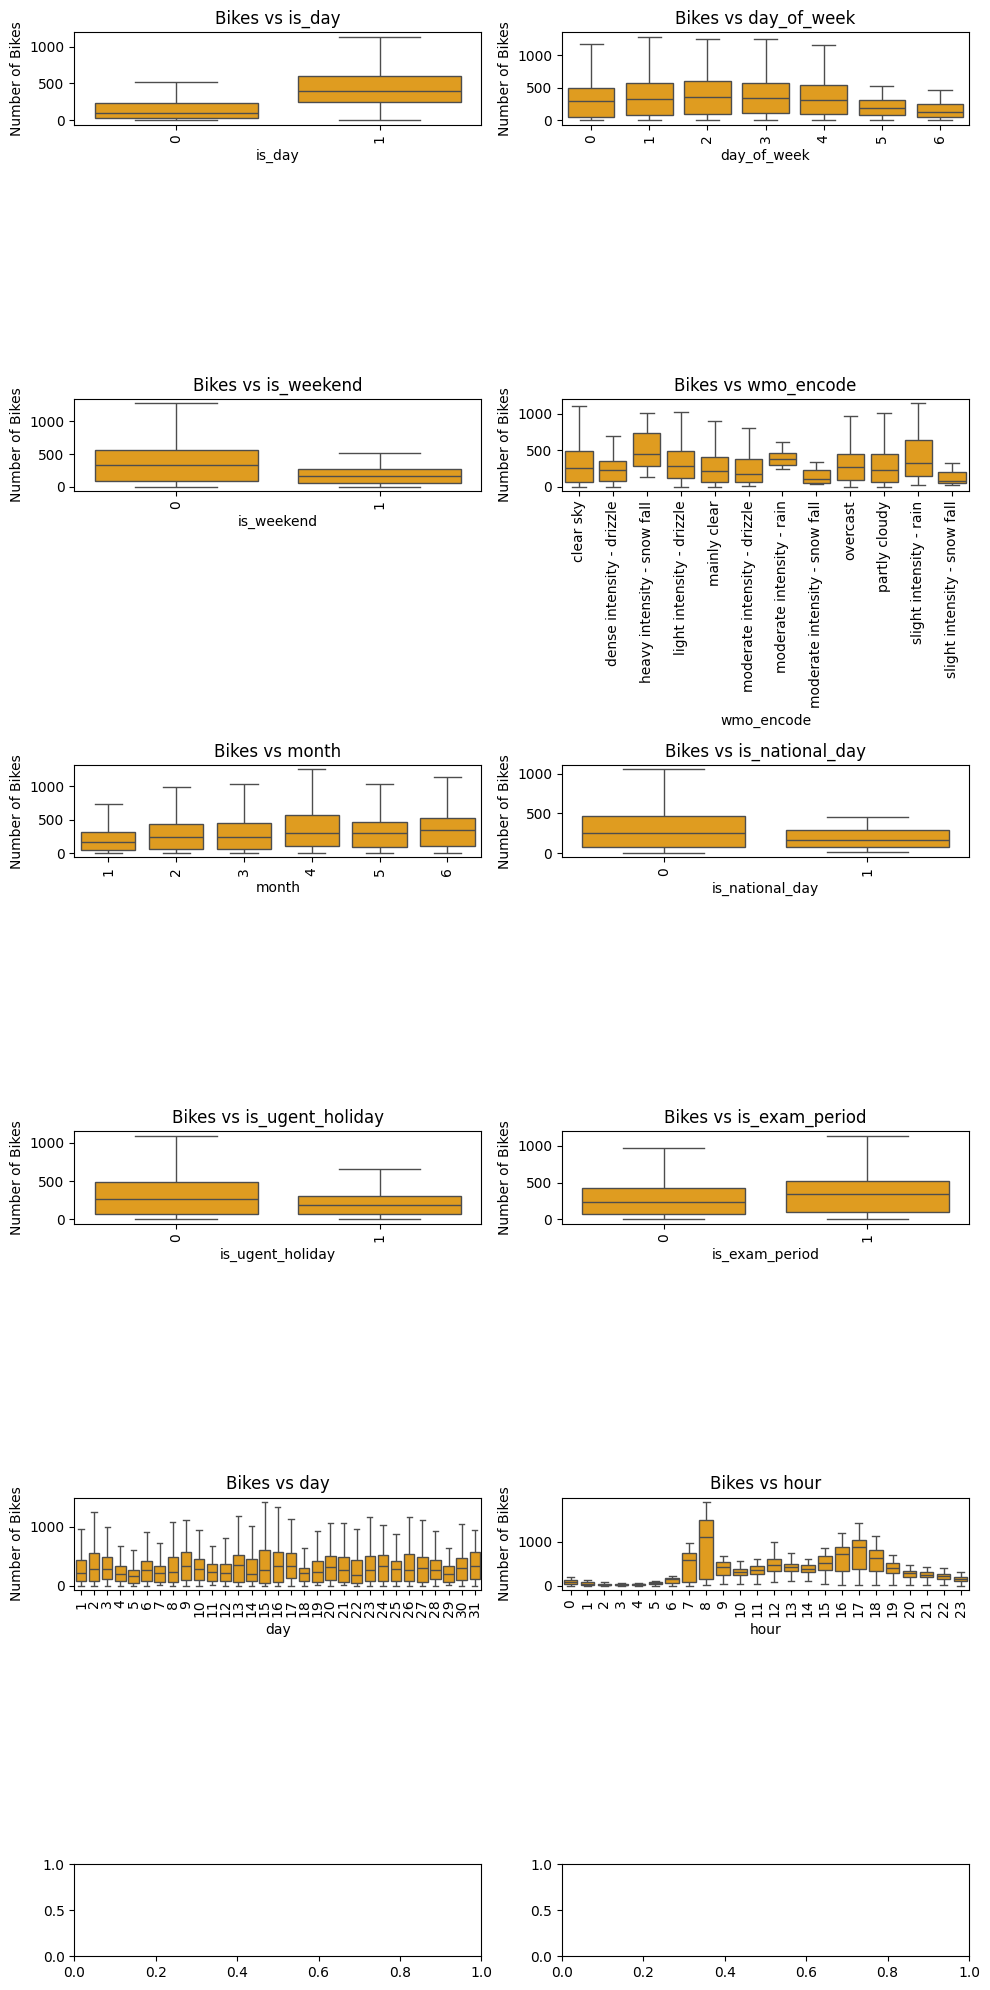

In [34]:
# create a 3 x 3 grid of subplots 
fig, axs = plt.subplots(6,2, figsize = (10,20))

# flatten array to make easier to access each subplot
axs = axs.ravel()

# loop over each column in the dataframe and plot a histogram
for i,column in enumerate(categorical_features):
    sns.boxplot(data=train_data, x=column, y='total', ax=axs[i], showfliers = False, color='orange')
    axs[i].set_xlabel(column)
    axs[i].set_ylabel("Number of Bikes")
    axs[i].set_title('Bikes vs {}'.format(column))
    axs[i].tick_params(axis='x', rotation=90)
    
plt.subplots_adjust(hspace=1)
plt.tight_layout()
plt.show()

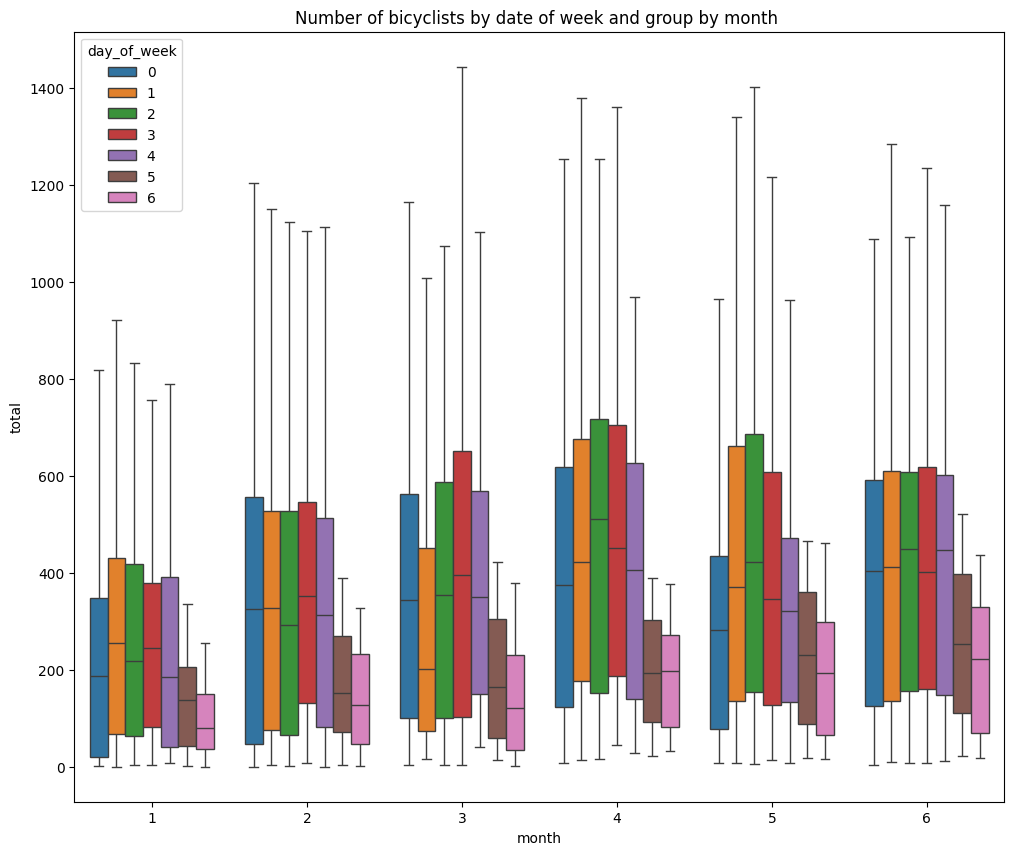

In [35]:
# This graph show a significant difference in total number of bicyclists' distributionbetween weekend and weekday by month

# plot the graph
plt.figure(figsize=(12, 10))
sns.boxplot(data=train_data, x="month", hue='day_of_week'
            ,y="total", showfliers=False)
plt.title("Number of bicyclists by date of week and group by month ")
plt.show()


I have generated a line graph depicting holiday events (weekends and official holidays) compared to working days, grouped by month. The graph highlights that the majority of holiday events exhibit lower peaks when compared to working days, indicating a drop in the number of bicyclists.

Furthermore, there is a distinct difference in the behavior of these two types of events. The pattern on working days displays three distinct peaks at different hours each day, while the lines for most holiday events remain relatively flat, lacking prominent peaks. This observation strongly supports the idea that there is a significant disparity in the bicyclist behavior between holiday events and regular days.

It's worth noting that these flatter lines are predominantly associated with weekend behavior.  Specifically, weekends exhibit a unique pattern compared to other holiday events, emphasizing the importance of considering weekends as a distinct feature in the model.

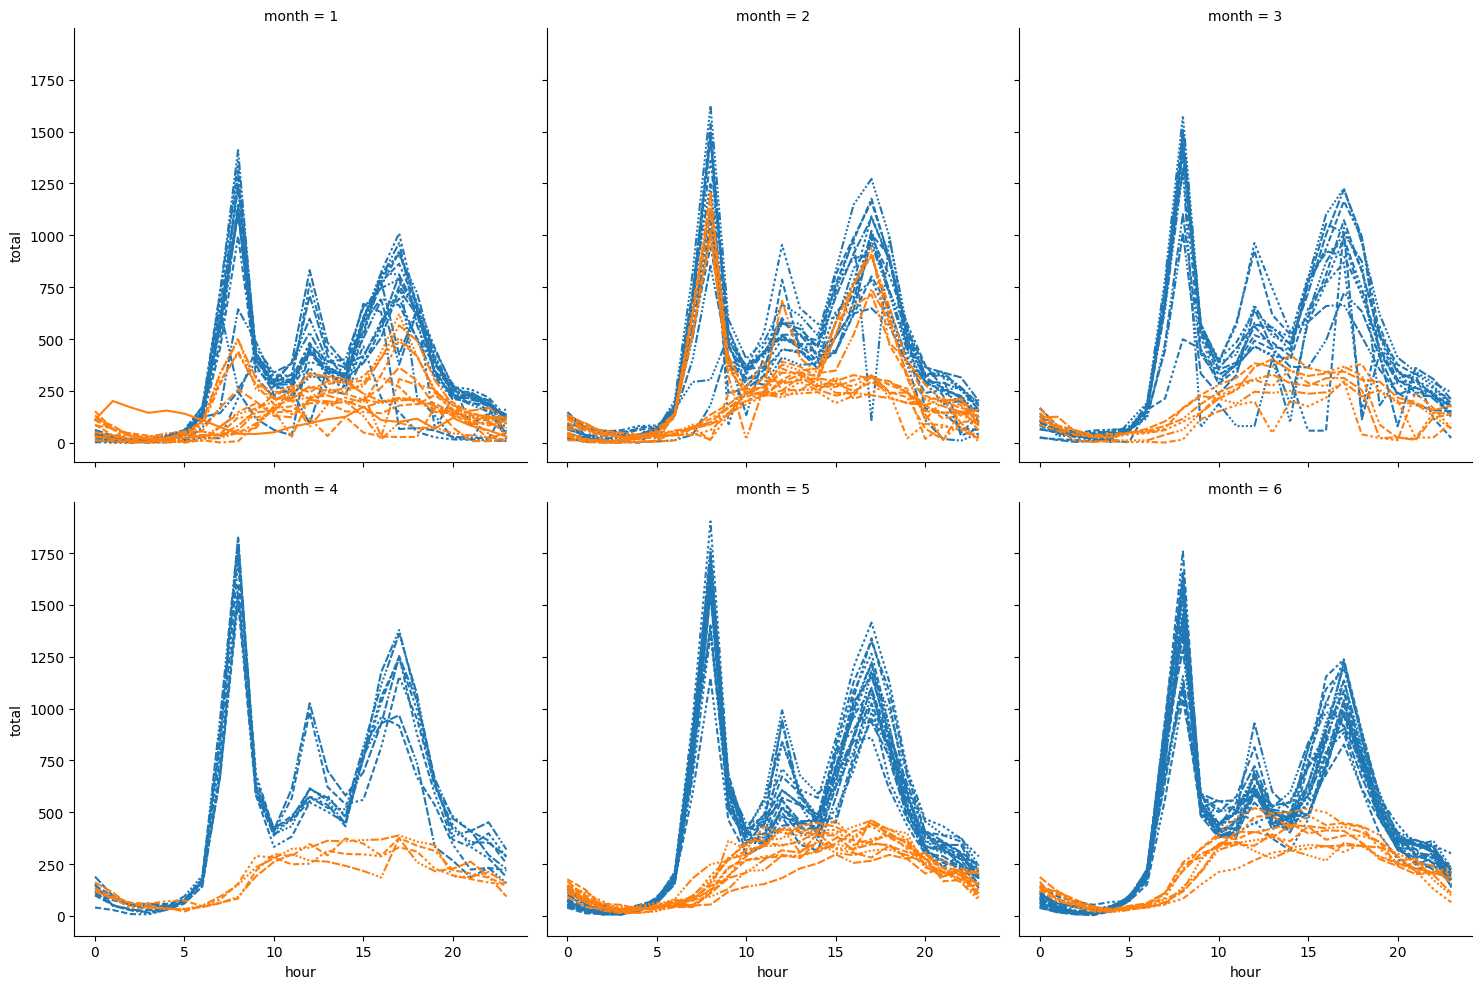

In [36]:
# plot line graph of holiday events and working days grouped by month (orange is holiday, blue is working day)

# generate data for ploting
plot_data = train_data[['hour','total','date','month','is_weekend','is_ugent_holiday','is_national_day']]
plot_data['is_holiday'] = plot_data.apply(lambda x: x['is_ugent_holiday']|x['is_weekend']|x['is_national_day'], axis=1)

# plot the graph
g = sns.relplot(
    data=plot_data, x="hour", y="total", col="month", col_wrap=3,
    hue="is_holiday", style="date", kind="line"
)
g._legend.remove()
plt.show()

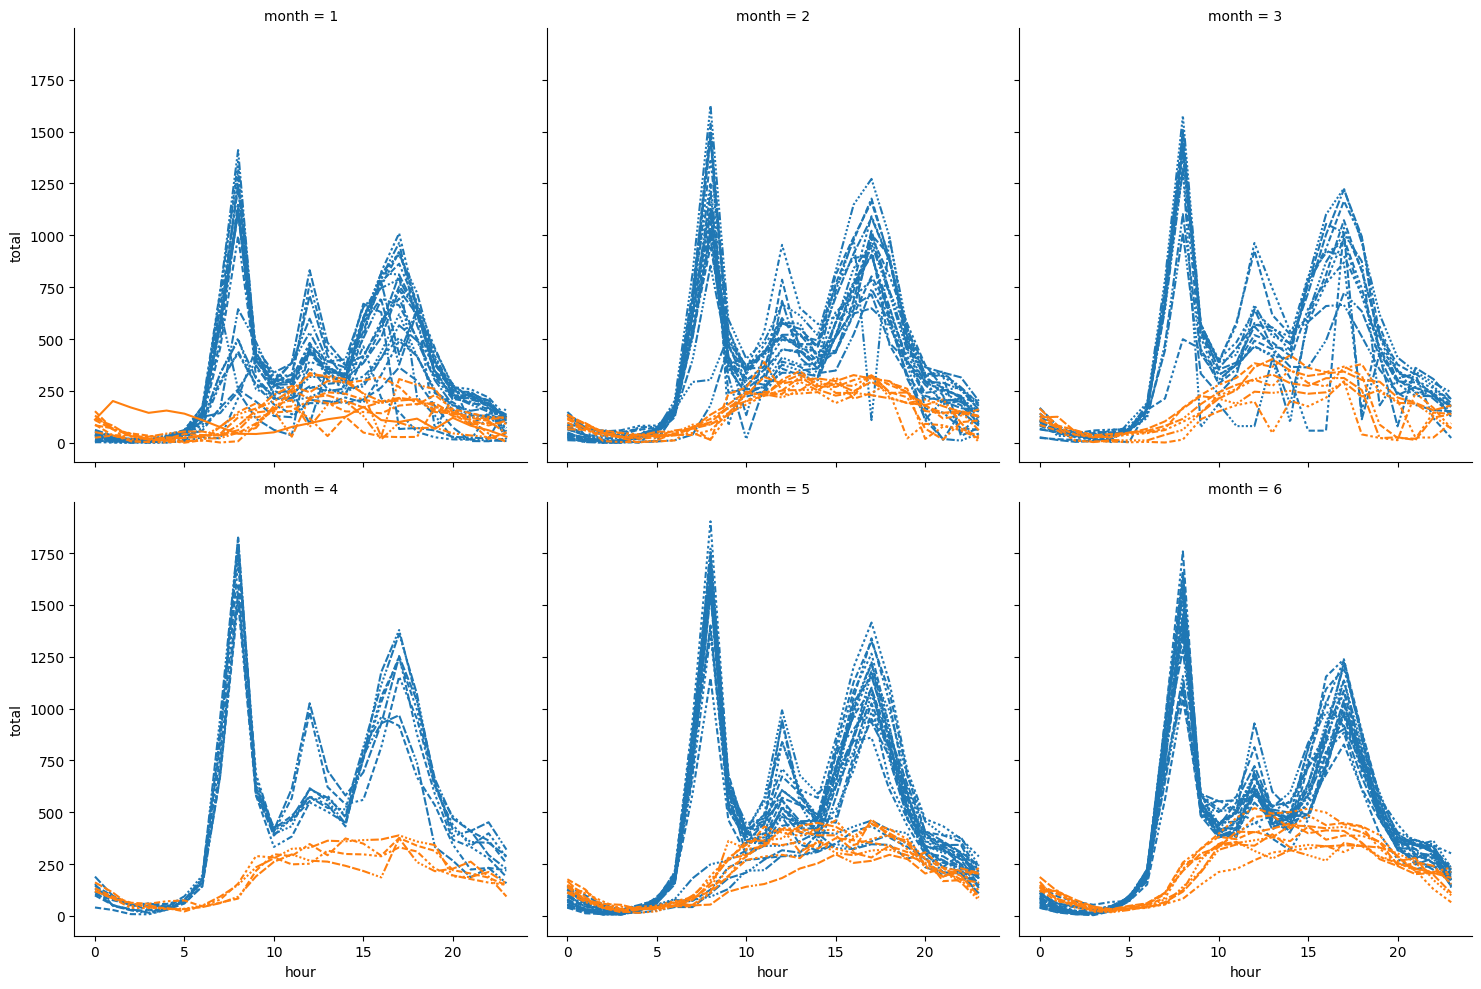

In [37]:
# plot line graph of weekend and working days grouped by month (orange is weekend, blue is working day) 
g = sns.relplot(
    data=train_data, x="hour", y="total", col="month", col_wrap=3,
    hue="is_weekend", style="date", kind="line"
)
g._legend.remove()
plt.show()

# Model

After thoroughly exploring the dataset, I've decided to employ a regression XGBoost model for the training data. This choice is motivated by several factors specific to this project. The dataset, being tabular, possesses a substantial volume, making XGBoost an apt choice. Additionally, XGBoost excels at capturing complex nonlinear relationships between features and the target variable, which proves beneficial in this case. Moreover, XGBoost, being an ensemble of decision trees, is particularly effective in capturing intricate relationships and interactions between features.

For data preprocessing, the following steps will be undertaken:

- Scaling continuous data
- Applying label encoding for categorical data
- Tree-based models, like XGBoost, are sensitive to the datatype of features, necessitating a conversion to ensure appropriateness.
- The weather feature is too detailed (contain too many information in one element), with each element containing both intensity and type information. Therefore, I have chosen to generate a weather type feature. This feature involves grouping together elements with the same weather type, aiming to simplify the learning process for the model by providing a more generalized representation of weather information.

Regarding data scaling, while tree-based models are generally not sensitive to feature scale due to their nature, I choose to scale continuous features for a couple of reasons. First I will I will apply regularization techniques into the XGBoost model. Since my features have different units, scaling ensures that the regularization terms are uniformly applied to all features. Additionally, although the absolute values of features may not be critical for tree-based models, scaling can contribute to improved model performance (sometimes, it doens't affect much) by accommodating the varied distributions and preventing potential overfitting.

In this project, I will employ the Poisson regression objective in XGBoost. This choice is informed by the nature of the data, which consists of count data. Utilizing Poisson regression aligns seamlessly with the characteristics of count-based response variables. Additionally, the Poisson regression framework ensures that the model's output remains non-negative, an essential feature when dealing with count data.

In [38]:
# generate feature whether type by grouping all same type weather together
def convert_weather_type(row):
    if row in ['clear sky']:
        return 'sunny'
    elif row in [ 'mainly clear', 'partly cloudy', 'overcast']:
        return 'cloudy'
    elif row in ['fog', 'depositing rime fog']:
        return 'fog'
    elif row in ['light intensity - drizzle', 'moderate intensity - drizzle', 'dense intensity - drizzle']:
        return "drizzle"
    elif row in ['light intesity - freezing drizzle', 'dense intesity - freezing drizzle']:
        return "freezing drizzle"
    elif row in ['slight intensity - rain', 'moderate intensity - rain', 'heavy intensity - rain']:
        return "rain"
    elif row in ['light intensity - freezing Rain', 'heavy intensity - freezing Rain']:
        return "freezing rain"
    elif row in ['slight intensity - snow fall', 'moderate intensity - snow fall', 'heavy intensity - snow fall']:
        return "snow"
    elif row in ['snow grains']:
        return "snow grains"
    elif row in ['slight - rain showers', 'moderate - rain showers', 'violent - rain showers']:
        return 'rain showers'
    elif row in ['slight - snow showers', 'heavy - snow showers']:
        return 'snow showers'
    elif row in ['slight thunderstorm: slight or moderate']:
        return 'thunderstorm'
    elif row in ['thunderstorm with slight hail', 'thunderstorm with heavy hail']:
        return 'hail'

# apply for trainning dataset
train_data['weather_type'] =  train_data['wmo_encode'].apply(convert_weather_type)

# apply for validation dataset
validation_data['weather_type'] =  validation_data['wmo_encode'].apply(convert_weather_type)

In [39]:
# assign nominal features
nominal_features =  ['is_day', 'is_weekend','is_national_day','is_ugent_holiday','wmo_encode'
                   ,'is_exam_period', 'day_of_week','weather_type','month', 'day','hour']

# select feature for training data set
X_train = train_data[continous_features+nominal_features]
y_train = train_data[target_feature]

# do label encoding for weather type and weather features
lbe_weather_type = LabelEncoder()
lbe_weather_type.fit(['sunny', 'cloudy', 'fog', 'drizzle', 'freezing drizzle', 'rain', 
         'freezing rain', 'snow', 'snow grains', 'rain showers', 
         'snow showers', 'thunderstorm', 'hail'])
X_train['weather_type'] = lbe_weather_type.transform(X_train['weather_type'])

lbe_weather = LabelEncoder()
lbe_weather.fit(list(wmo_dict.values()))
X_train['wmo_encode'] = lbe_weather.transform(X_train['wmo_encode'])

# scaling data
scaler = StandardScaler().fit(X_train[continous_features])
X_train[continous_features] = scaler.transform(X_train[continous_features])

# ensure catogorical data is in the true type.
X_train[nominal_features] = X_train[nominal_features].astype('category')

In [40]:
# apply the same transformation to validation dataset    
X_validation = validation_data[continous_features+nominal_features]
y_validation = validation_data[target_feature]

X_validation['weather_type'] = lbe_weather_type.transform(X_validation['weather_type'])
X_validation['wmo_encode'] = lbe_weather.transform(X_validation['wmo_encode'])

X_validation[continous_features] = scaler.transform(X_validation[continous_features])

X_validation[nominal_features] = X_validation[nominal_features].astype('category')

In [41]:
# check the columns of data before train
X_train.info()
X_validation.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3600 entries, 0 to 4006
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   direct_radiation      3600 non-null   float64 
 1   relativehumidity_2m   3600 non-null   float64 
 2   apparent_temperature  3600 non-null   float64 
 3   windspeed_10m         3600 non-null   float64 
 4   rain                  3600 non-null   float64 
 5   snow_depth            3600 non-null   float64 
 6   snowfall              3600 non-null   float64 
 7   is_day                3600 non-null   category
 8   is_weekend            3600 non-null   category
 9   is_national_day       3600 non-null   category
 10  is_ugent_holiday      3600 non-null   category
 11  wmo_encode            3600 non-null   category
 12  is_exam_period        3600 non-null   category
 13  day_of_week           3600 non-null   category
 14  weather_type          3600 non-null   category
 15  month    

During the tuning phase, I will employ randomized search to optimize the parameters for XGBoost. The dataset will undergo cross-validation with 4 folds to facilitate grid search. XGBoost's performance is notably sensitive to its parameters, and a well-tuned set can significantly enhance the model's effectiveness. Once an optimal parameter set is identified, I will retrain the model using the entire training dataset. This approach maximizes the use of all available data, ensuring the construction of a final model that exhibits strong generalization to unseen data.

In [42]:
# using randomized search
parameters = {'objective':['count:poisson'],
              'learning_rate': np.logspace(start=-5, stop=-1, num=50), 
              'max_depth': np.arange(2,5), # maximum depth of each tree
              'min_child_weight': np.arange(2,30),
              'n_estimators': [10000],
              "reg_alpha"   : [0.1,0.2,0.3,0.4,0.5], # L1 regularization term
              "reg_lambda"  : [0,1,2,3,4], # L2 regularization term
              "gamma"       : [0,1,2,3,4], # min_split_loss
             "colsample_bytree": [0.2, 0.4, 0.6], # fraction features
             "subsample":[0.6, 0.7, 0.8]} # fraction sample

xgb_model = XGBRegressor(tree_method="hist",enable_categorical=True)
xg_search = RandomizedSearchCV(xgb_model,parameters, n_iter=20, cv=4,scoring='r2',error_score='raise')
xg_search.fit(X_train, y_train)

RandomizedSearchCV(cv=4, error_score='raise',
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=True,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=...
       3.90693994e-02, 4.71486636e-02, 5.68986603e-02, 6.86648845e-02,
       8.28642773e-02, 1.00000000e-01]),
                                        'max_depth': array([2, 3, 4]),
                                        'min_child_weight': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
                                        'n_estimators': [10000],
                                        'objective': ['count:poisson'],
                                        'reg_alpha': [0.1, 0.2, 0.3, 0.4, 0.5],
                                        'reg_lambda': [0, 1, 2, 3, 4],
                                        'subsample': [0.6, 0.7, 0.8]},
                   scoring='r2')

In [43]:
# optimized parameter from randomized search
optimized_parameter = {'subsample': 0.7,
 'reg_lambda': 1,
 'reg_alpha': 0.4,
 'objective': 'count:poisson',
 'n_estimators': 10000,
 'min_child_weight': 5,
 'max_depth': 4,
 'learning_rate': 0.0019306977288832496,
 'gamma': 1,
 'colsample_bytree': 0.6}

# retrain whole dataset with optimized parameter, using early stopping
eval_set = [(X_train, y_train), (X_validation, y_validation)]
xgb_model = XGBRegressor(tree_method="hist",enable_categorical=True, random_state=42,**optimized_parameter)
xgb_model.fit(X_train, y_train,eval_metric="poisson-nloglik",early_stopping_rounds=30,eval_set=eval_set, verbose=True)

[0]	validation_0-poisson-nloglik:1946.59831	validation_1-poisson-nloglik:2011.60205
[1]	validation_0-poisson-nloglik:1946.15481	validation_1-poisson-nloglik:2011.14521
[2]	validation_0-poisson-nloglik:1945.71127	validation_1-poisson-nloglik:2010.68833
[3]	validation_0-poisson-nloglik:1945.26778	validation_1-poisson-nloglik:2010.23150
[4]	validation_0-poisson-nloglik:1944.82427	validation_1-poisson-nloglik:2009.77463
[5]	validation_0-poisson-nloglik:1944.38071	validation_1-poisson-nloglik:2009.31774
[6]	validation_0-poisson-nloglik:1943.93720	validation_1-poisson-nloglik:2008.86088
[7]	validation_0-poisson-nloglik:1943.49372	validation_1-poisson-nloglik:2008.40404
[8]	validation_0-poisson-nloglik:1943.05021	validation_1-poisson-nloglik:2007.94720
[9]	validation_0-poisson-nloglik:1942.60669	validation_1-poisson-nloglik:2007.49033
[10]	validation_0-poisson-nloglik:1942.16317	validation_1-poisson-nloglik:2007.03346
[11]	validation_0-poisson-nloglik:1941.71966	validation_1-poisson-nloglik:2

[97]	validation_0-poisson-nloglik:1903.58158	validation_1-poisson-nloglik:1967.29091
[98]	validation_0-poisson-nloglik:1903.13811	validation_1-poisson-nloglik:1966.83409
[99]	validation_0-poisson-nloglik:1902.69471	validation_1-poisson-nloglik:1966.37735
[100]	validation_0-poisson-nloglik:1902.25131	validation_1-poisson-nloglik:1965.92060
[101]	validation_0-poisson-nloglik:1901.80785	validation_1-poisson-nloglik:1965.46379
[102]	validation_0-poisson-nloglik:1901.36447	validation_1-poisson-nloglik:1965.00707
[103]	validation_0-poisson-nloglik:1900.92105	validation_1-poisson-nloglik:1964.55031
[104]	validation_0-poisson-nloglik:1900.47762	validation_1-poisson-nloglik:1964.09353
[105]	validation_0-poisson-nloglik:1900.03421	validation_1-poisson-nloglik:1963.63678
[106]	validation_0-poisson-nloglik:1899.59080	validation_1-poisson-nloglik:1963.18002
[107]	validation_0-poisson-nloglik:1899.14739	validation_1-poisson-nloglik:1962.72326
[108]	validation_0-poisson-nloglik:1898.70400	validation_

[193]	validation_0-poisson-nloglik:1861.01793	validation_1-poisson-nloglik:1923.44618
[194]	validation_0-poisson-nloglik:1860.57464	validation_1-poisson-nloglik:1922.98955
[195]	validation_0-poisson-nloglik:1860.13130	validation_1-poisson-nloglik:1922.53287
[196]	validation_0-poisson-nloglik:1859.68797	validation_1-poisson-nloglik:1922.07620
[197]	validation_0-poisson-nloglik:1859.24467	validation_1-poisson-nloglik:1921.61954
[198]	validation_0-poisson-nloglik:1858.80136	validation_1-poisson-nloglik:1921.16289
[199]	validation_0-poisson-nloglik:1858.35809	validation_1-poisson-nloglik:1920.70628
[200]	validation_0-poisson-nloglik:1857.91476	validation_1-poisson-nloglik:1920.24960
[201]	validation_0-poisson-nloglik:1857.47144	validation_1-poisson-nloglik:1919.79294
[202]	validation_0-poisson-nloglik:1857.02814	validation_1-poisson-nloglik:1919.33630
[203]	validation_0-poisson-nloglik:1856.58481	validation_1-poisson-nloglik:1918.87962
[204]	validation_0-poisson-nloglik:1856.14153	validati

[289]	validation_0-poisson-nloglik:1818.46526	validation_1-poisson-nloglik:1879.61245
[290]	validation_0-poisson-nloglik:1818.02208	validation_1-poisson-nloglik:1879.15592
[291]	validation_0-poisson-nloglik:1817.57888	validation_1-poisson-nloglik:1878.69938
[292]	validation_0-poisson-nloglik:1817.13571	validation_1-poisson-nloglik:1878.24285
[293]	validation_0-poisson-nloglik:1816.69251	validation_1-poisson-nloglik:1877.78632
[294]	validation_0-poisson-nloglik:1816.24932	validation_1-poisson-nloglik:1877.32978
[295]	validation_0-poisson-nloglik:1815.80614	validation_1-poisson-nloglik:1876.87325
[296]	validation_0-poisson-nloglik:1815.36297	validation_1-poisson-nloglik:1876.41675
[297]	validation_0-poisson-nloglik:1814.91978	validation_1-poisson-nloglik:1875.96021
[298]	validation_0-poisson-nloglik:1814.47659	validation_1-poisson-nloglik:1875.50367
[299]	validation_0-poisson-nloglik:1814.03341	validation_1-poisson-nloglik:1875.04715
[300]	validation_0-poisson-nloglik:1813.59020	validati

[385]	validation_0-poisson-nloglik:1775.92479	validation_1-poisson-nloglik:1835.79089
[386]	validation_0-poisson-nloglik:1775.48173	validation_1-poisson-nloglik:1835.33449
[387]	validation_0-poisson-nloglik:1775.03869	validation_1-poisson-nloglik:1834.87809
[388]	validation_0-poisson-nloglik:1774.59561	validation_1-poisson-nloglik:1834.42168
[389]	validation_0-poisson-nloglik:1774.15256	validation_1-poisson-nloglik:1833.96528
[390]	validation_0-poisson-nloglik:1773.70949	validation_1-poisson-nloglik:1833.50887
[391]	validation_0-poisson-nloglik:1773.26645	validation_1-poisson-nloglik:1833.05249
[392]	validation_0-poisson-nloglik:1772.82340	validation_1-poisson-nloglik:1832.59609
[393]	validation_0-poisson-nloglik:1772.38033	validation_1-poisson-nloglik:1832.13968
[394]	validation_0-poisson-nloglik:1771.93729	validation_1-poisson-nloglik:1831.68328
[395]	validation_0-poisson-nloglik:1771.49428	validation_1-poisson-nloglik:1831.22693
[396]	validation_0-poisson-nloglik:1771.05119	validati

[481]	validation_0-poisson-nloglik:1733.39834	validation_1-poisson-nloglik:1791.98335
[482]	validation_0-poisson-nloglik:1732.95545	validation_1-poisson-nloglik:1791.52712
[483]	validation_0-poisson-nloglik:1732.51253	validation_1-poisson-nloglik:1791.07086
[484]	validation_0-poisson-nloglik:1732.06965	validation_1-poisson-nloglik:1790.61463
[485]	validation_0-poisson-nloglik:1731.62675	validation_1-poisson-nloglik:1790.15839
[486]	validation_0-poisson-nloglik:1731.18386	validation_1-poisson-nloglik:1789.70216
[487]	validation_0-poisson-nloglik:1730.74096	validation_1-poisson-nloglik:1789.24591
[488]	validation_0-poisson-nloglik:1730.29807	validation_1-poisson-nloglik:1788.78967
[489]	validation_0-poisson-nloglik:1729.85520	validation_1-poisson-nloglik:1788.33345
[490]	validation_0-poisson-nloglik:1729.41228	validation_1-poisson-nloglik:1787.87720
[491]	validation_0-poisson-nloglik:1728.96941	validation_1-poisson-nloglik:1787.42098
[492]	validation_0-poisson-nloglik:1728.52653	validati

[577]	validation_0-poisson-nloglik:1690.88811	validation_1-poisson-nloglik:1748.19204
[578]	validation_0-poisson-nloglik:1690.44537	validation_1-poisson-nloglik:1747.73595
[579]	validation_0-poisson-nloglik:1690.00265	validation_1-poisson-nloglik:1747.27989
[580]	validation_0-poisson-nloglik:1689.55993	validation_1-poisson-nloglik:1746.82382
[581]	validation_0-poisson-nloglik:1689.11723	validation_1-poisson-nloglik:1746.36778
[582]	validation_0-poisson-nloglik:1688.67454	validation_1-poisson-nloglik:1745.91175
[583]	validation_0-poisson-nloglik:1688.23178	validation_1-poisson-nloglik:1745.45565
[584]	validation_0-poisson-nloglik:1687.78911	validation_1-poisson-nloglik:1744.99962
[585]	validation_0-poisson-nloglik:1687.34639	validation_1-poisson-nloglik:1744.54356
[586]	validation_0-poisson-nloglik:1686.90369	validation_1-poisson-nloglik:1744.08753
[587]	validation_0-poisson-nloglik:1686.46097	validation_1-poisson-nloglik:1743.63145
[588]	validation_0-poisson-nloglik:1686.01828	validati

[673]	validation_0-poisson-nloglik:1648.39620	validation_1-poisson-nloglik:1704.41905
[674]	validation_0-poisson-nloglik:1647.95371	validation_1-poisson-nloglik:1703.96321
[675]	validation_0-poisson-nloglik:1647.51119	validation_1-poisson-nloglik:1703.50735
[676]	validation_0-poisson-nloglik:1647.06867	validation_1-poisson-nloglik:1703.05148
[677]	validation_0-poisson-nloglik:1646.62615	validation_1-poisson-nloglik:1702.59562
[678]	validation_0-poisson-nloglik:1646.18366	validation_1-poisson-nloglik:1702.13977
[679]	validation_0-poisson-nloglik:1645.74116	validation_1-poisson-nloglik:1701.68394
[680]	validation_0-poisson-nloglik:1645.29864	validation_1-poisson-nloglik:1701.22807
[681]	validation_0-poisson-nloglik:1644.85616	validation_1-poisson-nloglik:1700.77224
[682]	validation_0-poisson-nloglik:1644.41365	validation_1-poisson-nloglik:1700.31639
[683]	validation_0-poisson-nloglik:1643.97117	validation_1-poisson-nloglik:1699.86057
[684]	validation_0-poisson-nloglik:1643.52862	validati

[769]	validation_0-poisson-nloglik:1605.92564	validation_1-poisson-nloglik:1660.66740
[770]	validation_0-poisson-nloglik:1605.48340	validation_1-poisson-nloglik:1660.21182
[771]	validation_0-poisson-nloglik:1605.04111	validation_1-poisson-nloglik:1659.75620
[772]	validation_0-poisson-nloglik:1604.59886	validation_1-poisson-nloglik:1659.30059
[773]	validation_0-poisson-nloglik:1604.15656	validation_1-poisson-nloglik:1658.84494
[774]	validation_0-poisson-nloglik:1603.71428	validation_1-poisson-nloglik:1658.38932
[775]	validation_0-poisson-nloglik:1603.27202	validation_1-poisson-nloglik:1657.93373
[776]	validation_0-poisson-nloglik:1602.82974	validation_1-poisson-nloglik:1657.47810
[777]	validation_0-poisson-nloglik:1602.38746	validation_1-poisson-nloglik:1657.02247
[778]	validation_0-poisson-nloglik:1601.94521	validation_1-poisson-nloglik:1656.56687
[779]	validation_0-poisson-nloglik:1601.50296	validation_1-poisson-nloglik:1656.11128
[780]	validation_0-poisson-nloglik:1601.06071	validati

[865]	validation_0-poisson-nloglik:1563.47906	validation_1-poisson-nloglik:1616.93976
[866]	validation_0-poisson-nloglik:1563.03702	validation_1-poisson-nloglik:1616.48438
[867]	validation_0-poisson-nloglik:1562.59503	validation_1-poisson-nloglik:1616.02904
[868]	validation_0-poisson-nloglik:1562.15303	validation_1-poisson-nloglik:1615.57369
[869]	validation_0-poisson-nloglik:1561.71098	validation_1-poisson-nloglik:1615.11829
[870]	validation_0-poisson-nloglik:1561.26900	validation_1-poisson-nloglik:1614.66297
[871]	validation_0-poisson-nloglik:1560.82701	validation_1-poisson-nloglik:1614.20764
[872]	validation_0-poisson-nloglik:1560.38503	validation_1-poisson-nloglik:1613.75232
[873]	validation_0-poisson-nloglik:1559.94300	validation_1-poisson-nloglik:1613.29695
[874]	validation_0-poisson-nloglik:1559.50103	validation_1-poisson-nloglik:1612.84163
[875]	validation_0-poisson-nloglik:1559.05903	validation_1-poisson-nloglik:1612.38627
[876]	validation_0-poisson-nloglik:1558.61705	validati

[961]	validation_0-poisson-nloglik:1521.05963	validation_1-poisson-nloglik:1573.23926
[962]	validation_0-poisson-nloglik:1520.61792	validation_1-poisson-nloglik:1572.78419
[963]	validation_0-poisson-nloglik:1520.17619	validation_1-poisson-nloglik:1572.32913
[964]	validation_0-poisson-nloglik:1519.73447	validation_1-poisson-nloglik:1571.87407
[965]	validation_0-poisson-nloglik:1519.29276	validation_1-poisson-nloglik:1571.41901
[966]	validation_0-poisson-nloglik:1518.85108	validation_1-poisson-nloglik:1570.96398
[967]	validation_0-poisson-nloglik:1518.40938	validation_1-poisson-nloglik:1570.50893
[968]	validation_0-poisson-nloglik:1517.96770	validation_1-poisson-nloglik:1570.05392
[969]	validation_0-poisson-nloglik:1517.52600	validation_1-poisson-nloglik:1569.59886
[970]	validation_0-poisson-nloglik:1517.08432	validation_1-poisson-nloglik:1569.14385
[971]	validation_0-poisson-nloglik:1516.64264	validation_1-poisson-nloglik:1568.68882
[972]	validation_0-poisson-nloglik:1516.20093	validati

[1056]	validation_0-poisson-nloglik:1479.11249	validation_1-poisson-nloglik:1530.02438
[1057]	validation_0-poisson-nloglik:1478.67110	validation_1-poisson-nloglik:1529.56965
[1058]	validation_0-poisson-nloglik:1478.22972	validation_1-poisson-nloglik:1529.11492
[1059]	validation_0-poisson-nloglik:1477.78838	validation_1-poisson-nloglik:1528.66024
[1060]	validation_0-poisson-nloglik:1477.34704	validation_1-poisson-nloglik:1528.20556
[1061]	validation_0-poisson-nloglik:1476.90565	validation_1-poisson-nloglik:1527.75083
[1062]	validation_0-poisson-nloglik:1476.46430	validation_1-poisson-nloglik:1527.29613
[1063]	validation_0-poisson-nloglik:1476.02297	validation_1-poisson-nloglik:1526.84145
[1064]	validation_0-poisson-nloglik:1475.58157	validation_1-poisson-nloglik:1526.38671
[1065]	validation_0-poisson-nloglik:1475.14027	validation_1-poisson-nloglik:1525.93206
[1066]	validation_0-poisson-nloglik:1474.69895	validation_1-poisson-nloglik:1525.47740
[1067]	validation_0-poisson-nloglik:1474.25

[1151]	validation_0-poisson-nloglik:1437.19980	validation_1-poisson-nloglik:1486.84397
[1152]	validation_0-poisson-nloglik:1436.75880	validation_1-poisson-nloglik:1486.38963
[1153]	validation_0-poisson-nloglik:1436.31780	validation_1-poisson-nloglik:1485.93528
[1154]	validation_0-poisson-nloglik:1435.87685	validation_1-poisson-nloglik:1485.48097
[1155]	validation_0-poisson-nloglik:1435.43584	validation_1-poisson-nloglik:1485.02663
[1156]	validation_0-poisson-nloglik:1434.99489	validation_1-poisson-nloglik:1484.57233
[1157]	validation_0-poisson-nloglik:1434.55395	validation_1-poisson-nloglik:1484.11806
[1158]	validation_0-poisson-nloglik:1434.11294	validation_1-poisson-nloglik:1483.66369
[1159]	validation_0-poisson-nloglik:1433.67201	validation_1-poisson-nloglik:1483.20943
[1160]	validation_0-poisson-nloglik:1433.23106	validation_1-poisson-nloglik:1482.75513
[1161]	validation_0-poisson-nloglik:1432.79010	validation_1-poisson-nloglik:1482.30082
[1162]	validation_0-poisson-nloglik:1432.34

[1246]	validation_0-poisson-nloglik:1395.32628	validation_1-poisson-nloglik:1443.70272
[1247]	validation_0-poisson-nloglik:1394.88573	validation_1-poisson-nloglik:1443.24882
[1248]	validation_0-poisson-nloglik:1394.44513	validation_1-poisson-nloglik:1442.79488
[1249]	validation_0-poisson-nloglik:1394.00466	validation_1-poisson-nloglik:1442.34107
[1250]	validation_0-poisson-nloglik:1393.56409	validation_1-poisson-nloglik:1441.88715
[1251]	validation_0-poisson-nloglik:1393.12357	validation_1-poisson-nloglik:1441.43328
[1252]	validation_0-poisson-nloglik:1392.68302	validation_1-poisson-nloglik:1440.97939
[1253]	validation_0-poisson-nloglik:1392.24252	validation_1-poisson-nloglik:1440.52555
[1254]	validation_0-poisson-nloglik:1391.80202	validation_1-poisson-nloglik:1440.07170
[1255]	validation_0-poisson-nloglik:1391.36149	validation_1-poisson-nloglik:1439.61783
[1256]	validation_0-poisson-nloglik:1390.92100	validation_1-poisson-nloglik:1439.16399
[1257]	validation_0-poisson-nloglik:1390.48

[1341]	validation_0-poisson-nloglik:1353.49721	validation_1-poisson-nloglik:1400.60591
[1342]	validation_0-poisson-nloglik:1353.05718	validation_1-poisson-nloglik:1400.15254
[1343]	validation_0-poisson-nloglik:1352.61712	validation_1-poisson-nloglik:1399.69915
[1344]	validation_0-poisson-nloglik:1352.17710	validation_1-poisson-nloglik:1399.24578
[1345]	validation_0-poisson-nloglik:1351.73703	validation_1-poisson-nloglik:1398.79237
[1346]	validation_0-poisson-nloglik:1351.29706	validation_1-poisson-nloglik:1398.33906
[1347]	validation_0-poisson-nloglik:1350.85703	validation_1-poisson-nloglik:1397.88567
[1348]	validation_0-poisson-nloglik:1350.41704	validation_1-poisson-nloglik:1397.43234
[1349]	validation_0-poisson-nloglik:1349.97699	validation_1-poisson-nloglik:1396.97895
[1350]	validation_0-poisson-nloglik:1349.53699	validation_1-poisson-nloglik:1396.52560
[1351]	validation_0-poisson-nloglik:1349.09702	validation_1-poisson-nloglik:1396.07228
[1352]	validation_0-poisson-nloglik:1348.65

[1436]	validation_0-poisson-nloglik:1311.71883	validation_1-poisson-nloglik:1357.55981
[1437]	validation_0-poisson-nloglik:1311.27932	validation_1-poisson-nloglik:1357.10696
[1438]	validation_0-poisson-nloglik:1310.83990	validation_1-poisson-nloglik:1356.65419
[1439]	validation_0-poisson-nloglik:1310.40041	validation_1-poisson-nloglik:1356.20137
[1440]	validation_0-poisson-nloglik:1309.96096	validation_1-poisson-nloglik:1355.74857
[1441]	validation_0-poisson-nloglik:1309.52149	validation_1-poisson-nloglik:1355.29575
[1442]	validation_0-poisson-nloglik:1309.08204	validation_1-poisson-nloglik:1354.84295
[1443]	validation_0-poisson-nloglik:1308.64260	validation_1-poisson-nloglik:1354.39017
[1444]	validation_0-poisson-nloglik:1308.20315	validation_1-poisson-nloglik:1353.93738
[1445]	validation_0-poisson-nloglik:1307.76375	validation_1-poisson-nloglik:1353.48464
[1446]	validation_0-poisson-nloglik:1307.32431	validation_1-poisson-nloglik:1353.03185
[1447]	validation_0-poisson-nloglik:1306.88

[1531]	validation_0-poisson-nloglik:1269.99798	validation_1-poisson-nloglik:1314.57124
[1532]	validation_0-poisson-nloglik:1269.55916	validation_1-poisson-nloglik:1314.11909
[1533]	validation_0-poisson-nloglik:1269.12033	validation_1-poisson-nloglik:1313.66690
[1534]	validation_0-poisson-nloglik:1268.68152	validation_1-poisson-nloglik:1313.21475
[1535]	validation_0-poisson-nloglik:1268.24269	validation_1-poisson-nloglik:1312.76257
[1536]	validation_0-poisson-nloglik:1267.80389	validation_1-poisson-nloglik:1312.31043
[1537]	validation_0-poisson-nloglik:1267.36509	validation_1-poisson-nloglik:1311.85829
[1538]	validation_0-poisson-nloglik:1266.92630	validation_1-poisson-nloglik:1311.40615
[1539]	validation_0-poisson-nloglik:1266.48750	validation_1-poisson-nloglik:1310.95400
[1540]	validation_0-poisson-nloglik:1266.04872	validation_1-poisson-nloglik:1310.50187
[1541]	validation_0-poisson-nloglik:1265.60997	validation_1-poisson-nloglik:1310.04979
[1542]	validation_0-poisson-nloglik:1265.17

[1626]	validation_0-poisson-nloglik:1228.34255	validation_1-poisson-nloglik:1271.64808
[1627]	validation_0-poisson-nloglik:1227.90448	validation_1-poisson-nloglik:1271.19667
[1628]	validation_0-poisson-nloglik:1227.46636	validation_1-poisson-nloglik:1270.74520
[1629]	validation_0-poisson-nloglik:1227.02829	validation_1-poisson-nloglik:1270.29378
[1630]	validation_0-poisson-nloglik:1226.59020	validation_1-poisson-nloglik:1269.84236
[1631]	validation_0-poisson-nloglik:1226.15216	validation_1-poisson-nloglik:1269.39097
[1632]	validation_0-poisson-nloglik:1225.71407	validation_1-poisson-nloglik:1268.93953
[1633]	validation_0-poisson-nloglik:1225.27605	validation_1-poisson-nloglik:1268.48817
[1634]	validation_0-poisson-nloglik:1224.83801	validation_1-poisson-nloglik:1268.03677
[1635]	validation_0-poisson-nloglik:1224.39996	validation_1-poisson-nloglik:1267.58539
[1636]	validation_0-poisson-nloglik:1223.96195	validation_1-poisson-nloglik:1267.13403
[1637]	validation_0-poisson-nloglik:1223.52

[1721]	validation_0-poisson-nloglik:1186.76155	validation_1-poisson-nloglik:1228.79935
[1722]	validation_0-poisson-nloglik:1186.32429	validation_1-poisson-nloglik:1228.34875
[1723]	validation_0-poisson-nloglik:1185.88701	validation_1-poisson-nloglik:1227.89812
[1724]	validation_0-poisson-nloglik:1185.44977	validation_1-poisson-nloglik:1227.44754
[1725]	validation_0-poisson-nloglik:1185.01255	validation_1-poisson-nloglik:1226.99698
[1726]	validation_0-poisson-nloglik:1184.57533	validation_1-poisson-nloglik:1226.54641
[1727]	validation_0-poisson-nloglik:1184.13811	validation_1-poisson-nloglik:1226.09584
[1728]	validation_0-poisson-nloglik:1183.70089	validation_1-poisson-nloglik:1225.64528
[1729]	validation_0-poisson-nloglik:1183.26373	validation_1-poisson-nloglik:1225.19478
[1730]	validation_0-poisson-nloglik:1182.82648	validation_1-poisson-nloglik:1224.74418
[1731]	validation_0-poisson-nloglik:1182.38931	validation_1-poisson-nloglik:1224.29367
[1732]	validation_0-poisson-nloglik:1181.95

[1816]	validation_0-poisson-nloglik:1145.26514	validation_1-poisson-nloglik:1186.03521
[1817]	validation_0-poisson-nloglik:1144.82882	validation_1-poisson-nloglik:1185.58555
[1818]	validation_0-poisson-nloglik:1144.39252	validation_1-poisson-nloglik:1185.13592
[1819]	validation_0-poisson-nloglik:1143.95621	validation_1-poisson-nloglik:1184.68625
[1820]	validation_0-poisson-nloglik:1143.51990	validation_1-poisson-nloglik:1184.23660
[1821]	validation_0-poisson-nloglik:1143.08365	validation_1-poisson-nloglik:1183.78700
[1822]	validation_0-poisson-nloglik:1142.64740	validation_1-poisson-nloglik:1183.33740
[1823]	validation_0-poisson-nloglik:1142.21115	validation_1-poisson-nloglik:1182.88781
[1824]	validation_0-poisson-nloglik:1141.77492	validation_1-poisson-nloglik:1182.43824
[1825]	validation_0-poisson-nloglik:1141.33869	validation_1-poisson-nloglik:1181.98867
[1826]	validation_0-poisson-nloglik:1140.90248	validation_1-poisson-nloglik:1181.53911
[1827]	validation_0-poisson-nloglik:1140.46

[1911]	validation_0-poisson-nloglik:1103.86489	validation_1-poisson-nloglik:1143.36723
[1912]	validation_0-poisson-nloglik:1103.42964	validation_1-poisson-nloglik:1142.91864
[1913]	validation_0-poisson-nloglik:1102.99441	validation_1-poisson-nloglik:1142.47007
[1914]	validation_0-poisson-nloglik:1102.55924	validation_1-poisson-nloglik:1142.02156
[1915]	validation_0-poisson-nloglik:1102.12404	validation_1-poisson-nloglik:1141.57302
[1916]	validation_0-poisson-nloglik:1101.68884	validation_1-poisson-nloglik:1141.12446
[1917]	validation_0-poisson-nloglik:1101.25366	validation_1-poisson-nloglik:1140.67595
[1918]	validation_0-poisson-nloglik:1100.81849	validation_1-poisson-nloglik:1140.22743
[1919]	validation_0-poisson-nloglik:1100.38338	validation_1-poisson-nloglik:1139.77897
[1920]	validation_0-poisson-nloglik:1099.94821	validation_1-poisson-nloglik:1139.33045
[1921]	validation_0-poisson-nloglik:1099.51309	validation_1-poisson-nloglik:1138.88200
[1922]	validation_0-poisson-nloglik:1099.07

[2006]	validation_0-poisson-nloglik:1062.57342	validation_1-poisson-nloglik:1100.80801
[2007]	validation_0-poisson-nloglik:1062.13937	validation_1-poisson-nloglik:1100.36062
[2008]	validation_0-poisson-nloglik:1061.70537	validation_1-poisson-nloglik:1099.91328
[2009]	validation_0-poisson-nloglik:1061.27136	validation_1-poisson-nloglik:1099.46593
[2010]	validation_0-poisson-nloglik:1060.83737	validation_1-poisson-nloglik:1099.01858
[2011]	validation_0-poisson-nloglik:1060.40336	validation_1-poisson-nloglik:1098.57124
[2012]	validation_0-poisson-nloglik:1059.96938	validation_1-poisson-nloglik:1098.12391
[2013]	validation_0-poisson-nloglik:1059.53544	validation_1-poisson-nloglik:1097.67662
[2014]	validation_0-poisson-nloglik:1059.10147	validation_1-poisson-nloglik:1097.22931
[2015]	validation_0-poisson-nloglik:1058.66751	validation_1-poisson-nloglik:1096.78200
[2016]	validation_0-poisson-nloglik:1058.23360	validation_1-poisson-nloglik:1096.33474
[2017]	validation_0-poisson-nloglik:1057.79

[2101]	validation_0-poisson-nloglik:1021.40347	validation_1-poisson-nloglik:1058.37080
[2102]	validation_0-poisson-nloglik:1020.97081	validation_1-poisson-nloglik:1057.92480
[2103]	validation_0-poisson-nloglik:1020.53817	validation_1-poisson-nloglik:1057.47881
[2104]	validation_0-poisson-nloglik:1020.10554	validation_1-poisson-nloglik:1057.03283
[2105]	validation_0-poisson-nloglik:1019.67295	validation_1-poisson-nloglik:1056.58690
[2106]	validation_0-poisson-nloglik:1019.24037	validation_1-poisson-nloglik:1056.14098
[2107]	validation_0-poisson-nloglik:1018.80783	validation_1-poisson-nloglik:1055.69509
[2108]	validation_0-poisson-nloglik:1018.37524	validation_1-poisson-nloglik:1055.24916
[2109]	validation_0-poisson-nloglik:1017.94269	validation_1-poisson-nloglik:1054.80327
[2110]	validation_0-poisson-nloglik:1017.51017	validation_1-poisson-nloglik:1054.35740
[2111]	validation_0-poisson-nloglik:1017.07766	validation_1-poisson-nloglik:1053.91154
[2112]	validation_0-poisson-nloglik:1016.64

[2196]	validation_0-poisson-nloglik:980.37567	validation_1-poisson-nloglik:1016.08082
[2197]	validation_0-poisson-nloglik:979.94462	validation_1-poisson-nloglik:1015.63641
[2198]	validation_0-poisson-nloglik:979.51355	validation_1-poisson-nloglik:1015.19199
[2199]	validation_0-poisson-nloglik:979.08257	validation_1-poisson-nloglik:1014.74828
[2200]	validation_0-poisson-nloglik:978.65167	validation_1-poisson-nloglik:1014.30475
[2201]	validation_0-poisson-nloglik:978.22068	validation_1-poisson-nloglik:1013.86040
[2202]	validation_0-poisson-nloglik:977.78970	validation_1-poisson-nloglik:1013.41607
[2203]	validation_0-poisson-nloglik:977.35885	validation_1-poisson-nloglik:1012.97225
[2204]	validation_0-poisson-nloglik:976.92792	validation_1-poisson-nloglik:1012.52889
[2205]	validation_0-poisson-nloglik:976.49699	validation_1-poisson-nloglik:1012.08461
[2206]	validation_0-poisson-nloglik:976.06609	validation_1-poisson-nloglik:1011.64036
[2207]	validation_0-poisson-nloglik:975.63526	validati

[2292]	validation_0-poisson-nloglik:939.08061	validation_1-poisson-nloglik:973.52456
[2293]	validation_0-poisson-nloglik:938.65147	validation_1-poisson-nloglik:973.08271
[2294]	validation_0-poisson-nloglik:938.22229	validation_1-poisson-nloglik:972.64089
[2295]	validation_0-poisson-nloglik:937.79305	validation_1-poisson-nloglik:972.19829
[2296]	validation_0-poisson-nloglik:937.36386	validation_1-poisson-nloglik:971.75584
[2297]	validation_0-poisson-nloglik:936.93498	validation_1-poisson-nloglik:971.36903
[2298]	validation_0-poisson-nloglik:936.50587	validation_1-poisson-nloglik:970.92674
[2299]	validation_0-poisson-nloglik:936.07674	validation_1-poisson-nloglik:970.48424
[2300]	validation_0-poisson-nloglik:935.64761	validation_1-poisson-nloglik:970.04176
[2301]	validation_0-poisson-nloglik:935.21851	validation_1-poisson-nloglik:969.59980
[2302]	validation_0-poisson-nloglik:934.78942	validation_1-poisson-nloglik:969.15735
[2303]	validation_0-poisson-nloglik:934.36047	validation_1-poisso

[2389]	validation_0-poisson-nloglik:897.54634	validation_1-poisson-nloglik:930.77747
[2390]	validation_0-poisson-nloglik:897.11913	validation_1-poisson-nloglik:930.33741
[2391]	validation_0-poisson-nloglik:896.69195	validation_1-poisson-nloglik:929.89721
[2392]	validation_0-poisson-nloglik:896.26478	validation_1-poisson-nloglik:929.45667
[2393]	validation_0-poisson-nloglik:895.83768	validation_1-poisson-nloglik:929.01618
[2394]	validation_0-poisson-nloglik:895.41065	validation_1-poisson-nloglik:928.57654
[2395]	validation_0-poisson-nloglik:894.98361	validation_1-poisson-nloglik:928.13644
[2396]	validation_0-poisson-nloglik:894.55665	validation_1-poisson-nloglik:927.69602
[2397]	validation_0-poisson-nloglik:894.12962	validation_1-poisson-nloglik:927.25561
[2398]	validation_0-poisson-nloglik:893.70261	validation_1-poisson-nloglik:926.81521
[2399]	validation_0-poisson-nloglik:893.27576	validation_1-poisson-nloglik:926.37527
[2400]	validation_0-poisson-nloglik:892.84885	validation_1-poisso

[2486]	validation_0-poisson-nloglik:856.22914	validation_1-poisson-nloglik:888.20167
[2487]	validation_0-poisson-nloglik:855.80437	validation_1-poisson-nloglik:887.76428
[2488]	validation_0-poisson-nloglik:855.37989	validation_1-poisson-nloglik:887.32681
[2489]	validation_0-poisson-nloglik:854.95538	validation_1-poisson-nloglik:886.88985
[2490]	validation_0-poisson-nloglik:854.53089	validation_1-poisson-nloglik:886.45234
[2491]	validation_0-poisson-nloglik:854.10620	validation_1-poisson-nloglik:886.01415
[2492]	validation_0-poisson-nloglik:853.68149	validation_1-poisson-nloglik:885.57603
[2493]	validation_0-poisson-nloglik:853.25679	validation_1-poisson-nloglik:885.13792
[2494]	validation_0-poisson-nloglik:852.83224	validation_1-poisson-nloglik:884.70095
[2495]	validation_0-poisson-nloglik:852.40756	validation_1-poisson-nloglik:884.26287
[2496]	validation_0-poisson-nloglik:851.98301	validation_1-poisson-nloglik:883.82483
[2497]	validation_0-poisson-nloglik:851.55866	validation_1-poisso

[2583]	validation_0-poisson-nloglik:815.16083	validation_1-poisson-nloglik:845.88694
[2584]	validation_0-poisson-nloglik:814.73860	validation_1-poisson-nloglik:845.45126
[2585]	validation_0-poisson-nloglik:814.31638	validation_1-poisson-nloglik:845.01559
[2586]	validation_0-poisson-nloglik:813.89474	validation_1-poisson-nloglik:844.58265
[2587]	validation_0-poisson-nloglik:813.47285	validation_1-poisson-nloglik:844.14791
[2588]	validation_0-poisson-nloglik:813.05076	validation_1-poisson-nloglik:843.71237
[2589]	validation_0-poisson-nloglik:812.62916	validation_1-poisson-nloglik:843.27799
[2590]	validation_0-poisson-nloglik:812.20711	validation_1-poisson-nloglik:842.84249
[2591]	validation_0-poisson-nloglik:811.78508	validation_1-poisson-nloglik:842.40702
[2592]	validation_0-poisson-nloglik:811.36370	validation_1-poisson-nloglik:841.97336
[2593]	validation_0-poisson-nloglik:810.94173	validation_1-poisson-nloglik:841.53794
[2594]	validation_0-poisson-nloglik:810.52026	validation_1-poisso

[2680]	validation_0-poisson-nloglik:774.37227	validation_1-poisson-nloglik:803.87178
[2681]	validation_0-poisson-nloglik:773.95336	validation_1-poisson-nloglik:803.44080
[2682]	validation_0-poisson-nloglik:773.53459	validation_1-poisson-nloglik:803.01004
[2683]	validation_0-poisson-nloglik:773.11582	validation_1-poisson-nloglik:802.57842
[2684]	validation_0-poisson-nloglik:772.69661	validation_1-poisson-nloglik:802.14572
[2685]	validation_0-poisson-nloglik:772.27750	validation_1-poisson-nloglik:801.71310
[2686]	validation_0-poisson-nloglik:771.85835	validation_1-poisson-nloglik:801.28047
[2687]	validation_0-poisson-nloglik:771.43926	validation_1-poisson-nloglik:800.84789
[2688]	validation_0-poisson-nloglik:771.02022	validation_1-poisson-nloglik:800.41534
[2689]	validation_0-poisson-nloglik:770.60120	validation_1-poisson-nloglik:799.98282
[2690]	validation_0-poisson-nloglik:770.18233	validation_1-poisson-nloglik:799.55035
[2691]	validation_0-poisson-nloglik:769.76338	validation_1-poisso

[2777]	validation_0-poisson-nloglik:733.89049	validation_1-poisson-nloglik:762.15105
[2778]	validation_0-poisson-nloglik:733.47496	validation_1-poisson-nloglik:761.72394
[2779]	validation_0-poisson-nloglik:733.05937	validation_1-poisson-nloglik:761.29585
[2780]	validation_0-poisson-nloglik:732.64394	validation_1-poisson-nloglik:760.86737
[2781]	validation_0-poisson-nloglik:732.22812	validation_1-poisson-nloglik:760.43801
[2782]	validation_0-poisson-nloglik:731.81281	validation_1-poisson-nloglik:760.01160
[2783]	validation_0-poisson-nloglik:731.39793	validation_1-poisson-nloglik:759.58412
[2784]	validation_0-poisson-nloglik:730.98275	validation_1-poisson-nloglik:759.15736
[2785]	validation_0-poisson-nloglik:730.56707	validation_1-poisson-nloglik:758.72813
[2786]	validation_0-poisson-nloglik:730.15194	validation_1-poisson-nloglik:758.30024
[2787]	validation_0-poisson-nloglik:729.73740	validation_1-poisson-nloglik:757.87304
[2788]	validation_0-poisson-nloglik:729.32264	validation_1-poisso

[2874]	validation_0-poisson-nloglik:693.76309	validation_1-poisson-nloglik:720.79296
[2875]	validation_0-poisson-nloglik:693.35091	validation_1-poisson-nloglik:720.36717
[2876]	validation_0-poisson-nloglik:692.93967	validation_1-poisson-nloglik:719.94519
[2877]	validation_0-poisson-nloglik:692.52855	validation_1-poisson-nloglik:719.52115
[2878]	validation_0-poisson-nloglik:692.11653	validation_1-poisson-nloglik:719.09549
[2879]	validation_0-poisson-nloglik:691.70556	validation_1-poisson-nloglik:718.67433
[2880]	validation_0-poisson-nloglik:691.29488	validation_1-poisson-nloglik:718.25185
[2881]	validation_0-poisson-nloglik:690.88394	validation_1-poisson-nloglik:717.82913
[2882]	validation_0-poisson-nloglik:690.47206	validation_1-poisson-nloglik:717.40362
[2883]	validation_0-poisson-nloglik:690.06089	validation_1-poisson-nloglik:716.98133
[2884]	validation_0-poisson-nloglik:689.64911	validation_1-poisson-nloglik:716.55593
[2885]	validation_0-poisson-nloglik:689.23791	validation_1-poisso

[2971]	validation_0-poisson-nloglik:654.03745	validation_1-poisson-nloglik:679.94399
[2972]	validation_0-poisson-nloglik:653.62955	validation_1-poisson-nloglik:679.52239
[2973]	validation_0-poisson-nloglik:653.22282	validation_1-poisson-nloglik:679.10510
[2974]	validation_0-poisson-nloglik:652.81502	validation_1-poisson-nloglik:678.68359
[2975]	validation_0-poisson-nloglik:652.40852	validation_1-poisson-nloglik:678.26553
[2976]	validation_0-poisson-nloglik:652.00080	validation_1-poisson-nloglik:677.84412
[2977]	validation_0-poisson-nloglik:651.59313	validation_1-poisson-nloglik:677.42275
[2978]	validation_0-poisson-nloglik:651.18681	validation_1-poisson-nloglik:677.00486
[2979]	validation_0-poisson-nloglik:650.77922	validation_1-poisson-nloglik:676.58358
[2980]	validation_0-poisson-nloglik:650.37292	validation_1-poisson-nloglik:676.16490
[2981]	validation_0-poisson-nloglik:649.96557	validation_1-poisson-nloglik:675.74374
[2982]	validation_0-poisson-nloglik:649.55815	validation_1-poisso

[3068]	validation_0-poisson-nloglik:614.75729	validation_1-poisson-nloglik:639.47074
[3069]	validation_0-poisson-nloglik:614.35532	validation_1-poisson-nloglik:639.05696
[3070]	validation_0-poisson-nloglik:613.95345	validation_1-poisson-nloglik:638.64390
[3071]	validation_0-poisson-nloglik:613.55040	validation_1-poisson-nloglik:638.22706
[3072]	validation_0-poisson-nloglik:613.14901	validation_1-poisson-nloglik:637.81490
[3073]	validation_0-poisson-nloglik:612.74651	validation_1-poisson-nloglik:637.39815
[3074]	validation_0-poisson-nloglik:612.34358	validation_1-poisson-nloglik:636.98145
[3075]	validation_0-poisson-nloglik:611.94205	validation_1-poisson-nloglik:636.56769
[3076]	validation_0-poisson-nloglik:611.53926	validation_1-poisson-nloglik:636.15110
[3077]	validation_0-poisson-nloglik:611.13654	validation_1-poisson-nloglik:635.73460
[3078]	validation_0-poisson-nloglik:610.73513	validation_1-poisson-nloglik:635.32058
[3079]	validation_0-poisson-nloglik:610.33381	validation_1-poisso

[3165]	validation_0-poisson-nloglik:575.96823	validation_1-poisson-nloglik:599.47500
[3166]	validation_0-poisson-nloglik:575.57046	validation_1-poisson-nloglik:599.06335
[3167]	validation_0-poisson-nloglik:575.17277	validation_1-poisson-nloglik:598.65177
[3168]	validation_0-poisson-nloglik:574.77631	validation_1-poisson-nloglik:598.24296
[3169]	validation_0-poisson-nloglik:574.37874	validation_1-poisson-nloglik:597.83149
[3170]	validation_0-poisson-nloglik:573.98252	validation_1-poisson-nloglik:597.42371
[3171]	validation_0-poisson-nloglik:573.58509	validation_1-poisson-nloglik:597.01239
[3172]	validation_0-poisson-nloglik:573.18894	validation_1-poisson-nloglik:596.60396
[3173]	validation_0-poisson-nloglik:572.79313	validation_1-poisson-nloglik:596.19909
[3174]	validation_0-poisson-nloglik:572.39704	validation_1-poisson-nloglik:595.79214
[3175]	validation_0-poisson-nloglik:571.99981	validation_1-poisson-nloglik:595.38102
[3176]	validation_0-poisson-nloglik:571.60262	validation_1-poisso

[3262]	validation_0-poisson-nloglik:537.73608	validation_1-poisson-nloglik:560.02841
[3263]	validation_0-poisson-nloglik:537.34531	validation_1-poisson-nloglik:559.62269
[3264]	validation_0-poisson-nloglik:536.95367	validation_1-poisson-nloglik:559.21708
[3265]	validation_0-poisson-nloglik:536.56325	validation_1-poisson-nloglik:558.81431
[3266]	validation_0-poisson-nloglik:536.17172	validation_1-poisson-nloglik:558.40880
[3267]	validation_0-poisson-nloglik:535.78130	validation_1-poisson-nloglik:558.00337
[3268]	validation_0-poisson-nloglik:535.38996	validation_1-poisson-nloglik:557.59803
[3269]	validation_0-poisson-nloglik:534.99875	validation_1-poisson-nloglik:557.19273
[3270]	validation_0-poisson-nloglik:534.60864	validation_1-poisson-nloglik:556.79195
[3271]	validation_0-poisson-nloglik:534.21926	validation_1-poisson-nloglik:556.39040
[3272]	validation_0-poisson-nloglik:533.82934	validation_1-poisson-nloglik:555.98940
[3273]	validation_0-poisson-nloglik:533.43936	validation_1-poisso

[3359]	validation_0-poisson-nloglik:500.12021	validation_1-poisson-nloglik:521.22157
[3360]	validation_0-poisson-nloglik:499.73649	validation_1-poisson-nloglik:520.82631
[3361]	validation_0-poisson-nloglik:499.35223	validation_1-poisson-nloglik:520.43026
[3362]	validation_0-poisson-nloglik:498.96737	validation_1-poisson-nloglik:520.03129
[3363]	validation_0-poisson-nloglik:498.58253	validation_1-poisson-nloglik:519.63235
[3364]	validation_0-poisson-nloglik:498.19910	validation_1-poisson-nloglik:519.23690
[3365]	validation_0-poisson-nloglik:497.81445	validation_1-poisson-nloglik:518.83813
[3366]	validation_0-poisson-nloglik:497.43001	validation_1-poisson-nloglik:518.43948
[3367]	validation_0-poisson-nloglik:497.04650	validation_1-poisson-nloglik:518.04366
[3368]	validation_0-poisson-nloglik:496.66209	validation_1-poisson-nloglik:517.64515
[3369]	validation_0-poisson-nloglik:496.27777	validation_1-poisson-nloglik:517.24670
[3370]	validation_0-poisson-nloglik:495.89455	validation_1-poisso

[3456]	validation_0-poisson-nloglik:463.17964	validation_1-poisson-nloglik:483.10794
[3457]	validation_0-poisson-nloglik:462.80272	validation_1-poisson-nloglik:482.71915
[3458]	validation_0-poisson-nloglik:462.42561	validation_1-poisson-nloglik:482.33895
[3459]	validation_0-poisson-nloglik:462.04832	validation_1-poisson-nloglik:481.94739
[3460]	validation_0-poisson-nloglik:461.67213	validation_1-poisson-nloglik:481.56104
[3461]	validation_0-poisson-nloglik:461.29576	validation_1-poisson-nloglik:481.17272
[3462]	validation_0-poisson-nloglik:460.91918	validation_1-poisson-nloglik:480.78547
[3463]	validation_0-poisson-nloglik:460.54224	validation_1-poisson-nloglik:480.39426
[3464]	validation_0-poisson-nloglik:460.16662	validation_1-poisson-nloglik:480.00767
[3465]	validation_0-poisson-nloglik:459.79027	validation_1-poisson-nloglik:479.62826
[3466]	validation_0-poisson-nloglik:459.41414	validation_1-poisson-nloglik:479.23728
[3467]	validation_0-poisson-nloglik:459.03869	validation_1-poisso

[3553]	validation_0-poisson-nloglik:427.01100	validation_1-poisson-nloglik:445.76038
[3554]	validation_0-poisson-nloglik:426.64235	validation_1-poisson-nloglik:445.38039
[3555]	validation_0-poisson-nloglik:426.27424	validation_1-poisson-nloglik:445.00411
[3556]	validation_0-poisson-nloglik:425.90546	validation_1-poisson-nloglik:444.62396
[3557]	validation_0-poisson-nloglik:425.53674	validation_1-poisson-nloglik:444.24081
[3558]	validation_0-poisson-nloglik:425.16928	validation_1-poisson-nloglik:443.86158
[3559]	validation_0-poisson-nloglik:424.80088	validation_1-poisson-nloglik:443.50450
[3560]	validation_0-poisson-nloglik:424.43338	validation_1-poisson-nloglik:443.12534
[3561]	validation_0-poisson-nloglik:424.06553	validation_1-poisson-nloglik:442.74824
[3562]	validation_0-poisson-nloglik:423.69726	validation_1-poisson-nloglik:442.36554
[3563]	validation_0-poisson-nloglik:423.33085	validation_1-poisson-nloglik:441.99099
[3564]	validation_0-poisson-nloglik:422.96332	validation_1-poisso

[3650]	validation_0-poisson-nloglik:391.70521	validation_1-poisson-nloglik:409.40960
[3651]	validation_0-poisson-nloglik:391.34610	validation_1-poisson-nloglik:409.03875
[3652]	validation_0-poisson-nloglik:390.98747	validation_1-poisson-nloglik:408.67022
[3653]	validation_0-poisson-nloglik:390.62813	validation_1-poisson-nloglik:408.29624
[3654]	validation_0-poisson-nloglik:390.27032	validation_1-poisson-nloglik:407.93042
[3655]	validation_0-poisson-nloglik:389.91326	validation_1-poisson-nloglik:407.56137
[3656]	validation_0-poisson-nloglik:389.55509	validation_1-poisson-nloglik:407.19724
[3657]	validation_0-poisson-nloglik:389.19612	validation_1-poisson-nloglik:406.82363
[3658]	validation_0-poisson-nloglik:388.83949	validation_1-poisson-nloglik:406.45228
[3659]	validation_0-poisson-nloglik:388.48157	validation_1-poisson-nloglik:406.08311
[3660]	validation_0-poisson-nloglik:388.12365	validation_1-poisson-nloglik:405.71226
[3661]	validation_0-poisson-nloglik:387.76533	validation_1-poisso

[3747]	validation_0-poisson-nloglik:357.40447	validation_1-poisson-nloglik:374.11803
[3748]	validation_0-poisson-nloglik:357.05727	validation_1-poisson-nloglik:373.75787
[3749]	validation_0-poisson-nloglik:356.70805	validation_1-poisson-nloglik:373.39373
[3750]	validation_0-poisson-nloglik:356.36017	validation_1-poisson-nloglik:373.03448
[3751]	validation_0-poisson-nloglik:356.01225	validation_1-poisson-nloglik:372.67433
[3752]	validation_0-poisson-nloglik:355.66512	validation_1-poisson-nloglik:372.31586
[3753]	validation_0-poisson-nloglik:355.31815	validation_1-poisson-nloglik:371.95963
[3754]	validation_0-poisson-nloglik:354.97095	validation_1-poisson-nloglik:371.62213
[3755]	validation_0-poisson-nloglik:354.62403	validation_1-poisson-nloglik:371.26406
[3756]	validation_0-poisson-nloglik:354.27703	validation_1-poisson-nloglik:370.90604
[3757]	validation_0-poisson-nloglik:353.92996	validation_1-poisson-nloglik:370.55039
[3758]	validation_0-poisson-nloglik:353.58370	validation_1-poisso

[3844]	validation_0-poisson-nloglik:324.21450	validation_1-poisson-nloglik:340.01383
[3845]	validation_0-poisson-nloglik:323.87722	validation_1-poisson-nloglik:339.66296
[3846]	validation_0-poisson-nloglik:323.54151	validation_1-poisson-nloglik:339.32052
[3847]	validation_0-poisson-nloglik:323.20659	validation_1-poisson-nloglik:338.97174
[3848]	validation_0-poisson-nloglik:322.87261	validation_1-poisson-nloglik:338.62418
[3849]	validation_0-poisson-nloglik:322.53743	validation_1-poisson-nloglik:338.28163
[3850]	validation_0-poisson-nloglik:322.20454	validation_1-poisson-nloglik:337.96040
[3851]	validation_0-poisson-nloglik:321.87124	validation_1-poisson-nloglik:337.61472
[3852]	validation_0-poisson-nloglik:321.53731	validation_1-poisson-nloglik:337.26983
[3853]	validation_0-poisson-nloglik:321.20104	validation_1-poisson-nloglik:336.91729
[3854]	validation_0-poisson-nloglik:320.86687	validation_1-poisson-nloglik:336.57199
[3855]	validation_0-poisson-nloglik:320.53177	validation_1-poisso

[3941]	validation_0-poisson-nloglik:292.31737	validation_1-poisson-nloglik:307.27820
[3942]	validation_0-poisson-nloglik:291.99768	validation_1-poisson-nloglik:306.96484
[3943]	validation_0-poisson-nloglik:291.67716	validation_1-poisson-nloglik:306.62861
[3944]	validation_0-poisson-nloglik:291.35456	validation_1-poisson-nloglik:306.29514
[3945]	validation_0-poisson-nloglik:291.03484	validation_1-poisson-nloglik:305.96249
[3946]	validation_0-poisson-nloglik:290.71398	validation_1-poisson-nloglik:305.63045
[3947]	validation_0-poisson-nloglik:290.39409	validation_1-poisson-nloglik:305.29601
[3948]	validation_0-poisson-nloglik:290.07157	validation_1-poisson-nloglik:304.95959
[3949]	validation_0-poisson-nloglik:289.74992	validation_1-poisson-nloglik:304.62474
[3950]	validation_0-poisson-nloglik:289.42750	validation_1-poisson-nloglik:304.29464
[3951]	validation_0-poisson-nloglik:289.10823	validation_1-poisson-nloglik:303.98409
[3952]	validation_0-poisson-nloglik:288.78548	validation_1-poisso

[4038]	validation_0-poisson-nloglik:261.79844	validation_1-poisson-nloglik:275.79163
[4039]	validation_0-poisson-nloglik:261.48865	validation_1-poisson-nloglik:275.47530
[4040]	validation_0-poisson-nloglik:261.19042	validation_1-poisson-nloglik:275.15714
[4041]	validation_0-poisson-nloglik:260.89141	validation_1-poisson-nloglik:274.83985
[4042]	validation_0-poisson-nloglik:260.58587	validation_1-poisson-nloglik:274.51913
[4043]	validation_0-poisson-nloglik:260.27769	validation_1-poisson-nloglik:274.19877
[4044]	validation_0-poisson-nloglik:259.96916	validation_1-poisson-nloglik:273.88612
[4045]	validation_0-poisson-nloglik:259.66057	validation_1-poisson-nloglik:273.57346
[4046]	validation_0-poisson-nloglik:259.35678	validation_1-poisson-nloglik:273.25298
[4047]	validation_0-poisson-nloglik:259.04832	validation_1-poisson-nloglik:272.94001
[4048]	validation_0-poisson-nloglik:258.74125	validation_1-poisson-nloglik:272.62013
[4049]	validation_0-poisson-nloglik:258.43410	validation_1-poisso

[4135]	validation_0-poisson-nloglik:232.97534	validation_1-poisson-nloglik:245.86374
[4136]	validation_0-poisson-nloglik:232.69182	validation_1-poisson-nloglik:245.56962
[4137]	validation_0-poisson-nloglik:232.39807	validation_1-poisson-nloglik:245.27393
[4138]	validation_0-poisson-nloglik:232.10573	validation_1-poisson-nloglik:244.97645
[4139]	validation_0-poisson-nloglik:231.82436	validation_1-poisson-nloglik:244.67084
[4140]	validation_0-poisson-nloglik:231.53297	validation_1-poisson-nloglik:244.37283
[4141]	validation_0-poisson-nloglik:231.24126	validation_1-poisson-nloglik:244.06796
[4142]	validation_0-poisson-nloglik:230.96300	validation_1-poisson-nloglik:243.78059
[4143]	validation_0-poisson-nloglik:230.68320	validation_1-poisson-nloglik:243.47709
[4144]	validation_0-poisson-nloglik:230.39622	validation_1-poisson-nloglik:243.17415
[4145]	validation_0-poisson-nloglik:230.10460	validation_1-poisson-nloglik:242.87372
[4146]	validation_0-poisson-nloglik:229.81365	validation_1-poisso

[4232]	validation_0-poisson-nloglik:205.93356	validation_1-poisson-nloglik:217.78646
[4233]	validation_0-poisson-nloglik:205.66812	validation_1-poisson-nloglik:217.50138
[4234]	validation_0-poisson-nloglik:205.40394	validation_1-poisson-nloglik:217.23096
[4235]	validation_0-poisson-nloglik:205.13036	validation_1-poisson-nloglik:216.95145
[4236]	validation_0-poisson-nloglik:204.85681	validation_1-poisson-nloglik:216.66359
[4237]	validation_0-poisson-nloglik:204.59496	validation_1-poisson-nloglik:216.43442
[4238]	validation_0-poisson-nloglik:204.33521	validation_1-poisson-nloglik:216.15173
[4239]	validation_0-poisson-nloglik:204.07668	validation_1-poisson-nloglik:215.88924
[4240]	validation_0-poisson-nloglik:203.80514	validation_1-poisson-nloglik:215.60532
[4241]	validation_0-poisson-nloglik:203.54435	validation_1-poisson-nloglik:215.36616
[4242]	validation_0-poisson-nloglik:203.26990	validation_1-poisson-nloglik:215.07958
[4243]	validation_0-poisson-nloglik:202.99764	validation_1-poisso

[4329]	validation_0-poisson-nloglik:180.69017	validation_1-poisson-nloglik:191.91037
[4330]	validation_0-poisson-nloglik:180.44631	validation_1-poisson-nloglik:191.65657
[4331]	validation_0-poisson-nloglik:180.20179	validation_1-poisson-nloglik:191.39641
[4332]	validation_0-poisson-nloglik:179.94807	validation_1-poisson-nloglik:191.13770
[4333]	validation_0-poisson-nloglik:179.70406	validation_1-poisson-nloglik:190.87818
[4334]	validation_0-poisson-nloglik:179.45455	validation_1-poisson-nloglik:190.62467
[4335]	validation_0-poisson-nloglik:179.20736	validation_1-poisson-nloglik:190.40136
[4336]	validation_0-poisson-nloglik:178.95481	validation_1-poisson-nloglik:190.13194
[4337]	validation_0-poisson-nloglik:178.71555	validation_1-poisson-nloglik:189.86862
[4338]	validation_0-poisson-nloglik:178.46208	validation_1-poisson-nloglik:189.61113
[4339]	validation_0-poisson-nloglik:178.20834	validation_1-poisson-nloglik:189.34622
[4340]	validation_0-poisson-nloglik:177.96839	validation_1-poisso

[4426]	validation_0-poisson-nloglik:157.39993	validation_1-poisson-nloglik:168.41199
[4427]	validation_0-poisson-nloglik:157.17786	validation_1-poisson-nloglik:168.17333
[4428]	validation_0-poisson-nloglik:156.94764	validation_1-poisson-nloglik:167.93361
[4429]	validation_0-poisson-nloglik:156.71450	validation_1-poisson-nloglik:167.69481
[4430]	validation_0-poisson-nloglik:156.49153	validation_1-poisson-nloglik:167.45013
[4431]	validation_0-poisson-nloglik:156.26008	validation_1-poisson-nloglik:167.22034
[4432]	validation_0-poisson-nloglik:156.02746	validation_1-poisson-nloglik:167.00076
[4433]	validation_0-poisson-nloglik:155.79534	validation_1-poisson-nloglik:166.76314
[4434]	validation_0-poisson-nloglik:155.56492	validation_1-poisson-nloglik:166.52440
[4435]	validation_0-poisson-nloglik:155.34105	validation_1-poisson-nloglik:166.36574
[4436]	validation_0-poisson-nloglik:155.10972	validation_1-poisson-nloglik:166.11812
[4437]	validation_0-poisson-nloglik:154.87936	validation_1-poisso

[4523]	validation_0-poisson-nloglik:136.22211	validation_1-poisson-nloglik:148.13335
[4524]	validation_0-poisson-nloglik:136.01139	validation_1-poisson-nloglik:147.92980
[4525]	validation_0-poisson-nloglik:135.80128	validation_1-poisson-nloglik:147.73073
[4526]	validation_0-poisson-nloglik:135.59141	validation_1-poisson-nloglik:147.51258
[4527]	validation_0-poisson-nloglik:135.38330	validation_1-poisson-nloglik:147.29573
[4528]	validation_0-poisson-nloglik:135.17798	validation_1-poisson-nloglik:147.10052
[4529]	validation_0-poisson-nloglik:134.97462	validation_1-poisson-nloglik:146.90452
[4530]	validation_0-poisson-nloglik:134.76966	validation_1-poisson-nloglik:146.78715
[4531]	validation_0-poisson-nloglik:134.56239	validation_1-poisson-nloglik:146.56646
[4532]	validation_0-poisson-nloglik:134.35796	validation_1-poisson-nloglik:146.36843
[4533]	validation_0-poisson-nloglik:134.15064	validation_1-poisson-nloglik:146.16159
[4534]	validation_0-poisson-nloglik:133.94406	validation_1-poisso

[4620]	validation_0-poisson-nloglik:117.18865	validation_1-poisson-nloglik:130.11068
[4621]	validation_0-poisson-nloglik:117.00323	validation_1-poisson-nloglik:130.00679
[4622]	validation_0-poisson-nloglik:116.82119	validation_1-poisson-nloglik:129.82256
[4623]	validation_0-poisson-nloglik:116.63858	validation_1-poisson-nloglik:129.69161
[4624]	validation_0-poisson-nloglik:116.45956	validation_1-poisson-nloglik:129.59906
[4625]	validation_0-poisson-nloglik:116.27457	validation_1-poisson-nloglik:129.42839
[4626]	validation_0-poisson-nloglik:116.10087	validation_1-poisson-nloglik:129.35602
[4627]	validation_0-poisson-nloglik:115.91442	validation_1-poisson-nloglik:129.16692
[4628]	validation_0-poisson-nloglik:115.72964	validation_1-poisson-nloglik:128.97406
[4629]	validation_0-poisson-nloglik:115.54547	validation_1-poisson-nloglik:128.79100
[4630]	validation_0-poisson-nloglik:115.36165	validation_1-poisson-nloglik:128.59164
[4631]	validation_0-poisson-nloglik:115.17900	validation_1-poisso

[4717]	validation_0-poisson-nloglik:100.39285	validation_1-poisson-nloglik:114.80419
[4718]	validation_0-poisson-nloglik:100.22774	validation_1-poisson-nloglik:114.64459
[4719]	validation_0-poisson-nloglik:100.08343	validation_1-poisson-nloglik:114.51789
[4720]	validation_0-poisson-nloglik:99.91923	validation_1-poisson-nloglik:114.35990
[4721]	validation_0-poisson-nloglik:99.76693	validation_1-poisson-nloglik:114.28410
[4722]	validation_0-poisson-nloglik:99.60716	validation_1-poisson-nloglik:114.12326
[4723]	validation_0-poisson-nloglik:99.45200	validation_1-poisson-nloglik:113.96979
[4724]	validation_0-poisson-nloglik:99.28931	validation_1-poisson-nloglik:113.80285
[4725]	validation_0-poisson-nloglik:99.12496	validation_1-poisson-nloglik:113.71269
[4726]	validation_0-poisson-nloglik:98.97619	validation_1-poisson-nloglik:113.56332
[4727]	validation_0-poisson-nloglik:98.82056	validation_1-poisson-nloglik:113.40428
[4728]	validation_0-poisson-nloglik:98.65587	validation_1-poisson-nloglik

[4815]	validation_0-poisson-nloglik:85.89484	validation_1-poisson-nloglik:101.11592
[4816]	validation_0-poisson-nloglik:85.76247	validation_1-poisson-nloglik:101.01952
[4817]	validation_0-poisson-nloglik:85.62050	validation_1-poisson-nloglik:100.87656
[4818]	validation_0-poisson-nloglik:85.47638	validation_1-poisson-nloglik:100.71728
[4819]	validation_0-poisson-nloglik:85.34690	validation_1-poisson-nloglik:100.62231
[4820]	validation_0-poisson-nloglik:85.20228	validation_1-poisson-nloglik:100.46428
[4821]	validation_0-poisson-nloglik:85.07743	validation_1-poisson-nloglik:100.36077
[4822]	validation_0-poisson-nloglik:84.96087	validation_1-poisson-nloglik:100.27399
[4823]	validation_0-poisson-nloglik:84.81771	validation_1-poisson-nloglik:100.11523
[4824]	validation_0-poisson-nloglik:84.69333	validation_1-poisson-nloglik:99.97404
[4825]	validation_0-poisson-nloglik:84.55196	validation_1-poisson-nloglik:99.83014
[4826]	validation_0-poisson-nloglik:84.41147	validation_1-poisson-nloglik:99.6

[4914]	validation_0-poisson-nloglik:73.62873	validation_1-poisson-nloglik:89.16958
[4915]	validation_0-poisson-nloglik:73.52717	validation_1-poisson-nloglik:89.11126
[4916]	validation_0-poisson-nloglik:73.42500	validation_1-poisson-nloglik:88.99977
[4917]	validation_0-poisson-nloglik:73.30437	validation_1-poisson-nloglik:88.86972
[4918]	validation_0-poisson-nloglik:73.20603	validation_1-poisson-nloglik:88.78276
[4919]	validation_0-poisson-nloglik:73.08191	validation_1-poisson-nloglik:88.68485
[4920]	validation_0-poisson-nloglik:72.98775	validation_1-poisson-nloglik:88.58381
[4921]	validation_0-poisson-nloglik:72.89413	validation_1-poisson-nloglik:88.54537
[4922]	validation_0-poisson-nloglik:72.80789	validation_1-poisson-nloglik:88.46714
[4923]	validation_0-poisson-nloglik:72.68573	validation_1-poisson-nloglik:88.36565
[4924]	validation_0-poisson-nloglik:72.56883	validation_1-poisson-nloglik:88.29236
[4925]	validation_0-poisson-nloglik:72.44969	validation_1-poisson-nloglik:88.16285
[492

[5013]	validation_0-poisson-nloglik:63.61809	validation_1-poisson-nloglik:79.51694
[5014]	validation_0-poisson-nloglik:63.53577	validation_1-poisson-nloglik:79.46934
[5015]	validation_0-poisson-nloglik:63.43136	validation_1-poisson-nloglik:79.34755
[5016]	validation_0-poisson-nloglik:63.35139	validation_1-poisson-nloglik:79.25080
[5017]	validation_0-poisson-nloglik:63.26761	validation_1-poisson-nloglik:79.17356
[5018]	validation_0-poisson-nloglik:63.16366	validation_1-poisson-nloglik:79.06170
[5019]	validation_0-poisson-nloglik:63.08185	validation_1-poisson-nloglik:78.98113
[5020]	validation_0-poisson-nloglik:63.00300	validation_1-poisson-nloglik:78.88940
[5021]	validation_0-poisson-nloglik:62.89966	validation_1-poisson-nloglik:78.76721
[5022]	validation_0-poisson-nloglik:62.79680	validation_1-poisson-nloglik:78.64996
[5023]	validation_0-poisson-nloglik:62.71830	validation_1-poisson-nloglik:78.61286
[5024]	validation_0-poisson-nloglik:62.63756	validation_1-poisson-nloglik:78.54077
[502

[5112]	validation_0-poisson-nloglik:55.35483	validation_1-poisson-nloglik:71.30055
[5113]	validation_0-poisson-nloglik:55.26557	validation_1-poisson-nloglik:71.19591
[5114]	validation_0-poisson-nloglik:55.18217	validation_1-poisson-nloglik:71.11673
[5115]	validation_0-poisson-nloglik:55.11809	validation_1-poisson-nloglik:71.04228
[5116]	validation_0-poisson-nloglik:55.05774	validation_1-poisson-nloglik:70.97730
[5117]	validation_0-poisson-nloglik:54.99345	validation_1-poisson-nloglik:70.91664
[5118]	validation_0-poisson-nloglik:54.93132	validation_1-poisson-nloglik:70.83634
[5119]	validation_0-poisson-nloglik:54.84753	validation_1-poisson-nloglik:70.73554
[5120]	validation_0-poisson-nloglik:54.75860	validation_1-poisson-nloglik:70.63573
[5121]	validation_0-poisson-nloglik:54.69724	validation_1-poisson-nloglik:70.58514
[5122]	validation_0-poisson-nloglik:54.63683	validation_1-poisson-nloglik:70.52008
[5123]	validation_0-poisson-nloglik:54.54655	validation_1-poisson-nloglik:70.43355
[512

[5211]	validation_0-poisson-nloglik:48.47113	validation_1-poisson-nloglik:64.24754
[5212]	validation_0-poisson-nloglik:48.39426	validation_1-poisson-nloglik:64.15439
[5213]	validation_0-poisson-nloglik:48.34406	validation_1-poisson-nloglik:64.14051
[5214]	validation_0-poisson-nloglik:48.28951	validation_1-poisson-nloglik:64.09385
[5215]	validation_0-poisson-nloglik:48.24139	validation_1-poisson-nloglik:64.04964
[5216]	validation_0-poisson-nloglik:48.18936	validation_1-poisson-nloglik:64.02854
[5217]	validation_0-poisson-nloglik:48.13978	validation_1-poisson-nloglik:64.00110
[5218]	validation_0-poisson-nloglik:48.06680	validation_1-poisson-nloglik:63.91254
[5219]	validation_0-poisson-nloglik:48.01596	validation_1-poisson-nloglik:63.87245
[5220]	validation_0-poisson-nloglik:47.93946	validation_1-poisson-nloglik:63.78533
[5221]	validation_0-poisson-nloglik:47.86471	validation_1-poisson-nloglik:63.70456
[5222]	validation_0-poisson-nloglik:47.79131	validation_1-poisson-nloglik:63.63135
[522

[5310]	validation_0-poisson-nloglik:42.69651	validation_1-poisson-nloglik:58.11050
[5311]	validation_0-poisson-nloglik:42.63081	validation_1-poisson-nloglik:58.02998
[5312]	validation_0-poisson-nloglik:42.59044	validation_1-poisson-nloglik:57.99881
[5313]	validation_0-poisson-nloglik:42.52584	validation_1-poisson-nloglik:57.92673
[5314]	validation_0-poisson-nloglik:42.48385	validation_1-poisson-nloglik:57.90821
[5315]	validation_0-poisson-nloglik:42.44394	validation_1-poisson-nloglik:57.86762
[5316]	validation_0-poisson-nloglik:42.38174	validation_1-poisson-nloglik:57.79401
[5317]	validation_0-poisson-nloglik:42.31653	validation_1-poisson-nloglik:57.72143
[5318]	validation_0-poisson-nloglik:42.27850	validation_1-poisson-nloglik:57.68155
[5319]	validation_0-poisson-nloglik:42.23675	validation_1-poisson-nloglik:57.63928
[5320]	validation_0-poisson-nloglik:42.17292	validation_1-poisson-nloglik:57.56043
[5321]	validation_0-poisson-nloglik:42.13370	validation_1-poisson-nloglik:57.50825
[532

[5409]	validation_0-poisson-nloglik:37.95463	validation_1-poisson-nloglik:53.01154
[5410]	validation_0-poisson-nloglik:37.90023	validation_1-poisson-nloglik:52.94871
[5411]	validation_0-poisson-nloglik:37.87001	validation_1-poisson-nloglik:52.91504
[5412]	validation_0-poisson-nloglik:37.81691	validation_1-poisson-nloglik:52.85097
[5413]	validation_0-poisson-nloglik:37.78495	validation_1-poisson-nloglik:52.83580
[5414]	validation_0-poisson-nloglik:37.75144	validation_1-poisson-nloglik:52.79702
[5415]	validation_0-poisson-nloglik:37.69718	validation_1-poisson-nloglik:52.73136
[5416]	validation_0-poisson-nloglik:37.64372	validation_1-poisson-nloglik:52.66227
[5417]	validation_0-poisson-nloglik:37.61151	validation_1-poisson-nloglik:52.63239
[5418]	validation_0-poisson-nloglik:37.55798	validation_1-poisson-nloglik:52.56540
[5419]	validation_0-poisson-nloglik:37.50380	validation_1-poisson-nloglik:52.51082
[5420]	validation_0-poisson-nloglik:37.47161	validation_1-poisson-nloglik:52.47233
[542

[5508]	validation_0-poisson-nloglik:33.95486	validation_1-poisson-nloglik:48.72957
[5509]	validation_0-poisson-nloglik:33.91005	validation_1-poisson-nloglik:48.67409
[5510]	validation_0-poisson-nloglik:33.88314	validation_1-poisson-nloglik:48.63408
[5511]	validation_0-poisson-nloglik:33.85747	validation_1-poisson-nloglik:48.61298
[5512]	validation_0-poisson-nloglik:33.82890	validation_1-poisson-nloglik:48.58545
[5513]	validation_0-poisson-nloglik:33.78607	validation_1-poisson-nloglik:48.54825
[5514]	validation_0-poisson-nloglik:33.74275	validation_1-poisson-nloglik:48.51104
[5515]	validation_0-poisson-nloglik:33.69809	validation_1-poisson-nloglik:48.45578
[5516]	validation_0-poisson-nloglik:33.67058	validation_1-poisson-nloglik:48.43682
[5517]	validation_0-poisson-nloglik:33.63274	validation_1-poisson-nloglik:48.40082
[5518]	validation_0-poisson-nloglik:33.58790	validation_1-poisson-nloglik:48.35350
[5519]	validation_0-poisson-nloglik:33.56275	validation_1-poisson-nloglik:48.31729
[552

[5607]	validation_0-poisson-nloglik:30.76722	validation_1-poisson-nloglik:45.32792
[5608]	validation_0-poisson-nloglik:30.73083	validation_1-poisson-nloglik:45.27933
[5609]	validation_0-poisson-nloglik:30.69290	validation_1-poisson-nloglik:45.24058
[5610]	validation_0-poisson-nloglik:30.67059	validation_1-poisson-nloglik:45.21513
[5611]	validation_0-poisson-nloglik:30.64831	validation_1-poisson-nloglik:45.17791
[5612]	validation_0-poisson-nloglik:30.60988	validation_1-poisson-nloglik:45.13767
[5613]	validation_0-poisson-nloglik:30.57436	validation_1-poisson-nloglik:45.09608
[5614]	validation_0-poisson-nloglik:30.55303	validation_1-poisson-nloglik:45.06946
[5615]	validation_0-poisson-nloglik:30.51691	validation_1-poisson-nloglik:45.02290
[5616]	validation_0-poisson-nloglik:30.48434	validation_1-poisson-nloglik:44.98696
[5617]	validation_0-poisson-nloglik:30.46367	validation_1-poisson-nloglik:44.95863
[5618]	validation_0-poisson-nloglik:30.44208	validation_1-poisson-nloglik:44.94732
[561

[5706]	validation_0-poisson-nloglik:28.02365	validation_1-poisson-nloglik:42.21676
[5707]	validation_0-poisson-nloglik:28.00615	validation_1-poisson-nloglik:42.19073
[5708]	validation_0-poisson-nloglik:27.98854	validation_1-poisson-nloglik:42.16736
[5709]	validation_0-poisson-nloglik:27.97028	validation_1-poisson-nloglik:42.14569
[5710]	validation_0-poisson-nloglik:27.95343	validation_1-poisson-nloglik:42.12246
[5711]	validation_0-poisson-nloglik:27.93565	validation_1-poisson-nloglik:42.09691
[5712]	validation_0-poisson-nloglik:27.91799	validation_1-poisson-nloglik:42.08131
[5713]	validation_0-poisson-nloglik:27.90086	validation_1-poisson-nloglik:42.06199
[5714]	validation_0-poisson-nloglik:27.87106	validation_1-poisson-nloglik:42.02080
[5715]	validation_0-poisson-nloglik:27.85333	validation_1-poisson-nloglik:41.99432
[5716]	validation_0-poisson-nloglik:27.83449	validation_1-poisson-nloglik:41.98428
[5717]	validation_0-poisson-nloglik:27.80638	validation_1-poisson-nloglik:41.95316
[571

[5805]	validation_0-poisson-nloglik:25.85945	validation_1-poisson-nloglik:39.80554
[5806]	validation_0-poisson-nloglik:25.83339	validation_1-poisson-nloglik:39.78028
[5807]	validation_0-poisson-nloglik:25.81835	validation_1-poisson-nloglik:39.77004
[5808]	validation_0-poisson-nloglik:25.80398	validation_1-poisson-nloglik:39.74866
[5809]	validation_0-poisson-nloglik:25.78873	validation_1-poisson-nloglik:39.72855
[5810]	validation_0-poisson-nloglik:25.76385	validation_1-poisson-nloglik:39.69445
[5811]	validation_0-poisson-nloglik:25.74933	validation_1-poisson-nloglik:39.67134
[5812]	validation_0-poisson-nloglik:25.73407	validation_1-poisson-nloglik:39.65104
[5813]	validation_0-poisson-nloglik:25.71935	validation_1-poisson-nloglik:39.64125
[5814]	validation_0-poisson-nloglik:25.69368	validation_1-poisson-nloglik:39.60653
[5815]	validation_0-poisson-nloglik:25.66841	validation_1-poisson-nloglik:39.57254
[5816]	validation_0-poisson-nloglik:25.64419	validation_1-poisson-nloglik:39.54213
[581

[5904]	validation_0-poisson-nloglik:24.07971	validation_1-poisson-nloglik:37.77656
[5905]	validation_0-poisson-nloglik:24.05795	validation_1-poisson-nloglik:37.74949
[5906]	validation_0-poisson-nloglik:24.03707	validation_1-poisson-nloglik:37.72556
[5907]	validation_0-poisson-nloglik:24.01618	validation_1-poisson-nloglik:37.69633
[5908]	validation_0-poisson-nloglik:23.99373	validation_1-poisson-nloglik:37.66691
[5909]	validation_0-poisson-nloglik:23.97189	validation_1-poisson-nloglik:37.64041
[5910]	validation_0-poisson-nloglik:23.95053	validation_1-poisson-nloglik:37.61121
[5911]	validation_0-poisson-nloglik:23.93075	validation_1-poisson-nloglik:37.58450
[5912]	validation_0-poisson-nloglik:23.91850	validation_1-poisson-nloglik:37.56833
[5913]	validation_0-poisson-nloglik:23.89672	validation_1-poisson-nloglik:37.54414
[5914]	validation_0-poisson-nloglik:23.88486	validation_1-poisson-nloglik:37.52554
[5915]	validation_0-poisson-nloglik:23.87210	validation_1-poisson-nloglik:37.50546
[591

[6003]	validation_0-poisson-nloglik:22.47866	validation_1-poisson-nloglik:35.96186
[6004]	validation_0-poisson-nloglik:22.45997	validation_1-poisson-nloglik:35.94193
[6005]	validation_0-poisson-nloglik:22.44163	validation_1-poisson-nloglik:35.91537
[6006]	validation_0-poisson-nloglik:22.43039	validation_1-poisson-nloglik:35.89568
[6007]	validation_0-poisson-nloglik:22.41294	validation_1-poisson-nloglik:35.87594
[6008]	validation_0-poisson-nloglik:22.40313	validation_1-poisson-nloglik:35.85980
[6009]	validation_0-poisson-nloglik:22.38462	validation_1-poisson-nloglik:35.83351
[6010]	validation_0-poisson-nloglik:22.37364	validation_1-poisson-nloglik:35.83463
[6011]	validation_0-poisson-nloglik:22.36353	validation_1-poisson-nloglik:35.81941
[6012]	validation_0-poisson-nloglik:22.34558	validation_1-poisson-nloglik:35.79371
[6013]	validation_0-poisson-nloglik:22.33521	validation_1-poisson-nloglik:35.77511
[6014]	validation_0-poisson-nloglik:22.32393	validation_1-poisson-nloglik:35.78228
[601

[6102]	validation_0-poisson-nloglik:21.17963	validation_1-poisson-nloglik:34.44635
[6103]	validation_0-poisson-nloglik:21.16274	validation_1-poisson-nloglik:34.42013
[6104]	validation_0-poisson-nloglik:21.14546	validation_1-poisson-nloglik:34.39616
[6105]	validation_0-poisson-nloglik:21.12814	validation_1-poisson-nloglik:34.37260
[6106]	validation_0-poisson-nloglik:21.11982	validation_1-poisson-nloglik:34.36654
[6107]	validation_0-poisson-nloglik:21.10379	validation_1-poisson-nloglik:34.34519
[6108]	validation_0-poisson-nloglik:21.09475	validation_1-poisson-nloglik:34.33640
[6109]	validation_0-poisson-nloglik:21.07870	validation_1-poisson-nloglik:34.31574
[6110]	validation_0-poisson-nloglik:21.06999	validation_1-poisson-nloglik:34.30794
[6111]	validation_0-poisson-nloglik:21.05393	validation_1-poisson-nloglik:34.28827
[6112]	validation_0-poisson-nloglik:21.04488	validation_1-poisson-nloglik:34.27962
[6113]	validation_0-poisson-nloglik:21.03700	validation_1-poisson-nloglik:34.26905
[611

[6201]	validation_0-poisson-nloglik:19.96195	validation_1-poisson-nloglik:32.96875
[6202]	validation_0-poisson-nloglik:19.94913	validation_1-poisson-nloglik:32.95714
[6203]	validation_0-poisson-nloglik:19.93530	validation_1-poisson-nloglik:32.94036
[6204]	validation_0-poisson-nloglik:19.92691	validation_1-poisson-nloglik:32.94394
[6205]	validation_0-poisson-nloglik:19.91317	validation_1-poisson-nloglik:32.92487
[6206]	validation_0-poisson-nloglik:19.90629	validation_1-poisson-nloglik:32.91751
[6207]	validation_0-poisson-nloglik:19.89855	validation_1-poisson-nloglik:32.90394
[6208]	validation_0-poisson-nloglik:19.88537	validation_1-poisson-nloglik:32.88450
[6209]	validation_0-poisson-nloglik:19.87770	validation_1-poisson-nloglik:32.87186
[6210]	validation_0-poisson-nloglik:19.86939	validation_1-poisson-nloglik:32.87716
[6211]	validation_0-poisson-nloglik:19.86155	validation_1-poisson-nloglik:32.86651
[6212]	validation_0-poisson-nloglik:19.85380	validation_1-poisson-nloglik:32.85335
[621

[6300]	validation_0-poisson-nloglik:18.94581	validation_1-poisson-nloglik:31.73602
[6301]	validation_0-poisson-nloglik:18.93865	validation_1-poisson-nloglik:31.74622
[6302]	validation_0-poisson-nloglik:18.92748	validation_1-poisson-nloglik:31.72967
[6303]	validation_0-poisson-nloglik:18.92095	validation_1-poisson-nloglik:31.73380
[6304]	validation_0-poisson-nloglik:18.91409	validation_1-poisson-nloglik:31.72266
[6305]	validation_0-poisson-nloglik:18.90159	validation_1-poisson-nloglik:31.70876
[6306]	validation_0-poisson-nloglik:18.89044	validation_1-poisson-nloglik:31.69127
[6307]	validation_0-poisson-nloglik:18.87816	validation_1-poisson-nloglik:31.67645
[6308]	validation_0-poisson-nloglik:18.86702	validation_1-poisson-nloglik:31.66205
[6309]	validation_0-poisson-nloglik:18.86052	validation_1-poisson-nloglik:31.64887
[6310]	validation_0-poisson-nloglik:18.84833	validation_1-poisson-nloglik:31.63274
[6311]	validation_0-poisson-nloglik:18.83736	validation_1-poisson-nloglik:31.61921
[631

[6399]	validation_0-poisson-nloglik:18.07582	validation_1-poisson-nloglik:30.69654
[6400]	validation_0-poisson-nloglik:18.06466	validation_1-poisson-nloglik:30.67948
[6401]	validation_0-poisson-nloglik:18.05825	validation_1-poisson-nloglik:30.68329
[6402]	validation_0-poisson-nloglik:18.04923	validation_1-poisson-nloglik:30.67040
[6403]	validation_0-poisson-nloglik:18.03918	validation_1-poisson-nloglik:30.65488
[6404]	validation_0-poisson-nloglik:18.02929	validation_1-poisson-nloglik:30.64952
[6405]	validation_0-poisson-nloglik:18.02311	validation_1-poisson-nloglik:30.65511
[6406]	validation_0-poisson-nloglik:18.01247	validation_1-poisson-nloglik:30.64391
[6407]	validation_0-poisson-nloglik:18.00707	validation_1-poisson-nloglik:30.63322
[6408]	validation_0-poisson-nloglik:18.00119	validation_1-poisson-nloglik:30.64217
[6409]	validation_0-poisson-nloglik:17.99100	validation_1-poisson-nloglik:30.62637
[6410]	validation_0-poisson-nloglik:17.98010	validation_1-poisson-nloglik:30.60980
[641

[6498]	validation_0-poisson-nloglik:17.28242	validation_1-poisson-nloglik:29.74347
[6499]	validation_0-poisson-nloglik:17.27364	validation_1-poisson-nloglik:29.73008
[6500]	validation_0-poisson-nloglik:17.26835	validation_1-poisson-nloglik:29.72031
[6501]	validation_0-poisson-nloglik:17.25843	validation_1-poisson-nloglik:29.70597
[6502]	validation_0-poisson-nloglik:17.24826	validation_1-poisson-nloglik:29.69409
[6503]	validation_0-poisson-nloglik:17.23826	validation_1-poisson-nloglik:29.68195
[6504]	validation_0-poisson-nloglik:17.23072	validation_1-poisson-nloglik:29.66952
[6505]	validation_0-poisson-nloglik:17.22190	validation_1-poisson-nloglik:29.65612
[6506]	validation_0-poisson-nloglik:17.21727	validation_1-poisson-nloglik:29.65510
[6507]	validation_0-poisson-nloglik:17.20711	validation_1-poisson-nloglik:29.64024
[6508]	validation_0-poisson-nloglik:17.19961	validation_1-poisson-nloglik:29.62985
[6509]	validation_0-poisson-nloglik:17.19512	validation_1-poisson-nloglik:29.62313
[651

[6597]	validation_0-poisson-nloglik:16.61030	validation_1-poisson-nloglik:28.91693
[6598]	validation_0-poisson-nloglik:16.60249	validation_1-poisson-nloglik:28.90650
[6599]	validation_0-poisson-nloglik:16.59794	validation_1-poisson-nloglik:28.90334
[6600]	validation_0-poisson-nloglik:16.59388	validation_1-poisson-nloglik:28.90655
[6601]	validation_0-poisson-nloglik:16.58566	validation_1-poisson-nloglik:28.89487
[6602]	validation_0-poisson-nloglik:16.58146	validation_1-poisson-nloglik:28.88664
[6603]	validation_0-poisson-nloglik:16.57639	validation_1-poisson-nloglik:28.89508
[6604]	validation_0-poisson-nloglik:16.57225	validation_1-poisson-nloglik:28.88809
[6605]	validation_0-poisson-nloglik:16.56453	validation_1-poisson-nloglik:28.87491
[6606]	validation_0-poisson-nloglik:16.55775	validation_1-poisson-nloglik:28.86353
[6607]	validation_0-poisson-nloglik:16.55025	validation_1-poisson-nloglik:28.85291
[6608]	validation_0-poisson-nloglik:16.54276	validation_1-poisson-nloglik:28.84243
[660

[6696]	validation_0-poisson-nloglik:16.04865	validation_1-poisson-nloglik:28.25485
[6697]	validation_0-poisson-nloglik:16.04503	validation_1-poisson-nloglik:28.24958
[6698]	validation_0-poisson-nloglik:16.04135	validation_1-poisson-nloglik:28.24540
[6699]	validation_0-poisson-nloglik:16.03512	validation_1-poisson-nloglik:28.23628
[6700]	validation_0-poisson-nloglik:16.02843	validation_1-poisson-nloglik:28.22501
[6701]	validation_0-poisson-nloglik:16.02178	validation_1-poisson-nloglik:28.21480
[6702]	validation_0-poisson-nloglik:16.01828	validation_1-poisson-nloglik:28.21135
[6703]	validation_0-poisson-nloglik:16.01443	validation_1-poisson-nloglik:28.20366
[6704]	validation_0-poisson-nloglik:16.01093	validation_1-poisson-nloglik:28.19767
[6705]	validation_0-poisson-nloglik:16.00761	validation_1-poisson-nloglik:28.19859
[6706]	validation_0-poisson-nloglik:16.00440	validation_1-poisson-nloglik:28.19883
[6707]	validation_0-poisson-nloglik:15.99760	validation_1-poisson-nloglik:28.19441
[670

[6795]	validation_0-poisson-nloglik:15.54592	validation_1-poisson-nloglik:27.65131
[6796]	validation_0-poisson-nloglik:15.54287	validation_1-poisson-nloglik:27.64639
[6797]	validation_0-poisson-nloglik:15.53670	validation_1-poisson-nloglik:27.63700
[6798]	validation_0-poisson-nloglik:15.53066	validation_1-poisson-nloglik:27.63234
[6799]	validation_0-poisson-nloglik:15.52741	validation_1-poisson-nloglik:27.62270
[6800]	validation_0-poisson-nloglik:15.52057	validation_1-poisson-nloglik:27.61361
[6801]	validation_0-poisson-nloglik:15.51691	validation_1-poisson-nloglik:27.60544
[6802]	validation_0-poisson-nloglik:15.51001	validation_1-poisson-nloglik:27.59589
[6803]	validation_0-poisson-nloglik:15.50431	validation_1-poisson-nloglik:27.58892
[6804]	validation_0-poisson-nloglik:15.50150	validation_1-poisson-nloglik:27.58874
[6805]	validation_0-poisson-nloglik:15.49781	validation_1-poisson-nloglik:27.58279
[6806]	validation_0-poisson-nloglik:15.49134	validation_1-poisson-nloglik:27.57288
[680

[6894]	validation_0-poisson-nloglik:15.09356	validation_1-poisson-nloglik:27.10584
[6895]	validation_0-poisson-nloglik:15.08793	validation_1-poisson-nloglik:27.09665
[6896]	validation_0-poisson-nloglik:15.08474	validation_1-poisson-nloglik:27.08982
[6897]	validation_0-poisson-nloglik:15.07886	validation_1-poisson-nloglik:27.08028
[6898]	validation_0-poisson-nloglik:15.07298	validation_1-poisson-nloglik:27.07108
[6899]	validation_0-poisson-nloglik:15.06733	validation_1-poisson-nloglik:27.06246
[6900]	validation_0-poisson-nloglik:15.06347	validation_1-poisson-nloglik:27.07091
[6901]	validation_0-poisson-nloglik:15.05735	validation_1-poisson-nloglik:27.06067
[6902]	validation_0-poisson-nloglik:15.05235	validation_1-poisson-nloglik:27.05591
[6903]	validation_0-poisson-nloglik:15.04957	validation_1-poisson-nloglik:27.05033
[6904]	validation_0-poisson-nloglik:15.04386	validation_1-poisson-nloglik:27.04219
[6905]	validation_0-poisson-nloglik:15.04116	validation_1-poisson-nloglik:27.03555
[690

[6993]	validation_0-poisson-nloglik:14.67672	validation_1-poisson-nloglik:26.61583
[6994]	validation_0-poisson-nloglik:14.67357	validation_1-poisson-nloglik:26.61883
[6995]	validation_0-poisson-nloglik:14.66855	validation_1-poisson-nloglik:26.61428
[6996]	validation_0-poisson-nloglik:14.66303	validation_1-poisson-nloglik:26.60609
[6997]	validation_0-poisson-nloglik:14.66003	validation_1-poisson-nloglik:26.60904
[6998]	validation_0-poisson-nloglik:14.65488	validation_1-poisson-nloglik:26.59990
[6999]	validation_0-poisson-nloglik:14.65254	validation_1-poisson-nloglik:26.59506
[7000]	validation_0-poisson-nloglik:14.64952	validation_1-poisson-nloglik:26.60242
[7001]	validation_0-poisson-nloglik:14.64377	validation_1-poisson-nloglik:26.59354
[7002]	validation_0-poisson-nloglik:14.63807	validation_1-poisson-nloglik:26.58429
[7003]	validation_0-poisson-nloglik:14.63238	validation_1-poisson-nloglik:26.57566
[7004]	validation_0-poisson-nloglik:14.63005	validation_1-poisson-nloglik:26.57356
[700

[7092]	validation_0-poisson-nloglik:14.30243	validation_1-poisson-nloglik:26.17648
[7093]	validation_0-poisson-nloglik:14.29858	validation_1-poisson-nloglik:26.17303
[7094]	validation_0-poisson-nloglik:14.29612	validation_1-poisson-nloglik:26.16844
[7095]	validation_0-poisson-nloglik:14.29373	validation_1-poisson-nloglik:26.16202
[7096]	validation_0-poisson-nloglik:14.29126	validation_1-poisson-nloglik:26.15691
[7097]	validation_0-poisson-nloglik:14.28860	validation_1-poisson-nloglik:26.15429
[7098]	validation_0-poisson-nloglik:14.28434	validation_1-poisson-nloglik:26.14691
[7099]	validation_0-poisson-nloglik:14.27964	validation_1-poisson-nloglik:26.14173
[7100]	validation_0-poisson-nloglik:14.27521	validation_1-poisson-nloglik:26.13492
[7101]	validation_0-poisson-nloglik:14.27108	validation_1-poisson-nloglik:26.12867
[7102]	validation_0-poisson-nloglik:14.26886	validation_1-poisson-nloglik:26.13055
[7103]	validation_0-poisson-nloglik:14.26446	validation_1-poisson-nloglik:26.12432
[710

[7191]	validation_0-poisson-nloglik:13.95977	validation_1-poisson-nloglik:25.77447
[7192]	validation_0-poisson-nloglik:13.95615	validation_1-poisson-nloglik:25.77842
[7193]	validation_0-poisson-nloglik:13.95162	validation_1-poisson-nloglik:25.77207
[7194]	validation_0-poisson-nloglik:13.94972	validation_1-poisson-nloglik:25.76833
[7195]	validation_0-poisson-nloglik:13.94633	validation_1-poisson-nloglik:25.76382
[7196]	validation_0-poisson-nloglik:13.94103	validation_1-poisson-nloglik:25.75605
[7197]	validation_0-poisson-nloglik:13.93673	validation_1-poisson-nloglik:25.74863
[7198]	validation_0-poisson-nloglik:13.93266	validation_1-poisson-nloglik:25.74286
[7199]	validation_0-poisson-nloglik:13.92981	validation_1-poisson-nloglik:25.73723
[7200]	validation_0-poisson-nloglik:13.92552	validation_1-poisson-nloglik:25.72986
[7201]	validation_0-poisson-nloglik:13.92361	validation_1-poisson-nloglik:25.72778
[7202]	validation_0-poisson-nloglik:13.92197	validation_1-poisson-nloglik:25.72663
[720

[7290]	validation_0-poisson-nloglik:13.64778	validation_1-poisson-nloglik:25.40635
[7291]	validation_0-poisson-nloglik:13.64381	validation_1-poisson-nloglik:25.40288
[7292]	validation_0-poisson-nloglik:13.64013	validation_1-poisson-nloglik:25.39800
[7293]	validation_0-poisson-nloglik:13.63691	validation_1-poisson-nloglik:25.39448
[7294]	validation_0-poisson-nloglik:13.63289	validation_1-poisson-nloglik:25.38781
[7295]	validation_0-poisson-nloglik:13.63061	validation_1-poisson-nloglik:25.39031
[7296]	validation_0-poisson-nloglik:13.62909	validation_1-poisson-nloglik:25.38687
[7297]	validation_0-poisson-nloglik:13.62746	validation_1-poisson-nloglik:25.38548
[7298]	validation_0-poisson-nloglik:13.62570	validation_1-poisson-nloglik:25.39034
[7299]	validation_0-poisson-nloglik:13.62349	validation_1-poisson-nloglik:25.38746
[7300]	validation_0-poisson-nloglik:13.62196	validation_1-poisson-nloglik:25.38547
[7301]	validation_0-poisson-nloglik:13.61961	validation_1-poisson-nloglik:25.39139
[730

[7389]	validation_0-poisson-nloglik:13.38484	validation_1-poisson-nloglik:25.12046
[7390]	validation_0-poisson-nloglik:13.38127	validation_1-poisson-nloglik:25.12125
[7391]	validation_0-poisson-nloglik:13.37779	validation_1-poisson-nloglik:25.11701
[7392]	validation_0-poisson-nloglik:13.37648	validation_1-poisson-nloglik:25.11590
[7393]	validation_0-poisson-nloglik:13.37473	validation_1-poisson-nloglik:25.11233
[7394]	validation_0-poisson-nloglik:13.37233	validation_1-poisson-nloglik:25.10905
[7395]	validation_0-poisson-nloglik:13.36962	validation_1-poisson-nloglik:25.10577
[7396]	validation_0-poisson-nloglik:13.36814	validation_1-poisson-nloglik:25.10622
[7397]	validation_0-poisson-nloglik:13.36646	validation_1-poisson-nloglik:25.10424
[7398]	validation_0-poisson-nloglik:13.36312	validation_1-poisson-nloglik:25.09965
[7399]	validation_0-poisson-nloglik:13.36120	validation_1-poisson-nloglik:25.09949
[7400]	validation_0-poisson-nloglik:13.35752	validation_1-poisson-nloglik:25.09389
[740

[7488]	validation_0-poisson-nloglik:13.13304	validation_1-poisson-nloglik:24.81764
[7489]	validation_0-poisson-nloglik:13.12967	validation_1-poisson-nloglik:24.81338
[7490]	validation_0-poisson-nloglik:13.12661	validation_1-poisson-nloglik:24.80908
[7491]	validation_0-poisson-nloglik:13.12327	validation_1-poisson-nloglik:24.80390
[7492]	validation_0-poisson-nloglik:13.11956	validation_1-poisson-nloglik:24.79788
[7493]	validation_0-poisson-nloglik:13.11570	validation_1-poisson-nloglik:24.79213
[7494]	validation_0-poisson-nloglik:13.11261	validation_1-poisson-nloglik:24.78655
[7495]	validation_0-poisson-nloglik:13.11153	validation_1-poisson-nloglik:24.78390
[7496]	validation_0-poisson-nloglik:13.10908	validation_1-poisson-nloglik:24.77885
[7497]	validation_0-poisson-nloglik:13.10799	validation_1-poisson-nloglik:24.77696
[7498]	validation_0-poisson-nloglik:13.10483	validation_1-poisson-nloglik:24.77219
[7499]	validation_0-poisson-nloglik:13.10345	validation_1-poisson-nloglik:24.77179
[750

[7587]	validation_0-poisson-nloglik:12.91415	validation_1-poisson-nloglik:24.55437
[7588]	validation_0-poisson-nloglik:12.91123	validation_1-poisson-nloglik:24.54930
[7589]	validation_0-poisson-nloglik:12.90862	validation_1-poisson-nloglik:24.54499
[7590]	validation_0-poisson-nloglik:12.90579	validation_1-poisson-nloglik:24.54065
[7591]	validation_0-poisson-nloglik:12.90485	validation_1-poisson-nloglik:24.53861
[7592]	validation_0-poisson-nloglik:12.90355	validation_1-poisson-nloglik:24.53632
[7593]	validation_0-poisson-nloglik:12.90256	validation_1-poisson-nloglik:24.53476
[7594]	validation_0-poisson-nloglik:12.90167	validation_1-poisson-nloglik:24.53179
[7595]	validation_0-poisson-nloglik:12.89843	validation_1-poisson-nloglik:24.52669
[7596]	validation_0-poisson-nloglik:12.89730	validation_1-poisson-nloglik:24.52538
[7597]	validation_0-poisson-nloglik:12.89442	validation_1-poisson-nloglik:24.52073
[7598]	validation_0-poisson-nloglik:12.89185	validation_1-poisson-nloglik:24.51721
[759

[7686]	validation_0-poisson-nloglik:12.70473	validation_1-poisson-nloglik:24.31558
[7687]	validation_0-poisson-nloglik:12.70258	validation_1-poisson-nloglik:24.31253
[7688]	validation_0-poisson-nloglik:12.70041	validation_1-poisson-nloglik:24.30924
[7689]	validation_0-poisson-nloglik:12.69941	validation_1-poisson-nloglik:24.30773
[7690]	validation_0-poisson-nloglik:12.69606	validation_1-poisson-nloglik:24.30514
[7691]	validation_0-poisson-nloglik:12.69452	validation_1-poisson-nloglik:24.30155
[7692]	validation_0-poisson-nloglik:12.69123	validation_1-poisson-nloglik:24.29718
[7693]	validation_0-poisson-nloglik:12.68925	validation_1-poisson-nloglik:24.29459
[7694]	validation_0-poisson-nloglik:12.68655	validation_1-poisson-nloglik:24.29099
[7695]	validation_0-poisson-nloglik:12.68364	validation_1-poisson-nloglik:24.28671
[7696]	validation_0-poisson-nloglik:12.68279	validation_1-poisson-nloglik:24.28578
[7697]	validation_0-poisson-nloglik:12.68124	validation_1-poisson-nloglik:24.28397
[769

[7785]	validation_0-poisson-nloglik:12.50243	validation_1-poisson-nloglik:24.10295
[7786]	validation_0-poisson-nloglik:12.50049	validation_1-poisson-nloglik:24.10262
[7787]	validation_0-poisson-nloglik:12.49892	validation_1-poisson-nloglik:24.10296
[7788]	validation_0-poisson-nloglik:12.49767	validation_1-poisson-nloglik:24.10063
[7789]	validation_0-poisson-nloglik:12.49520	validation_1-poisson-nloglik:24.09927
[7790]	validation_0-poisson-nloglik:12.49436	validation_1-poisson-nloglik:24.09885
[7791]	validation_0-poisson-nloglik:12.49322	validation_1-poisson-nloglik:24.09515
[7792]	validation_0-poisson-nloglik:12.48986	validation_1-poisson-nloglik:24.09250
[7793]	validation_0-poisson-nloglik:12.48830	validation_1-poisson-nloglik:24.09552
[7794]	validation_0-poisson-nloglik:12.48657	validation_1-poisson-nloglik:24.09332
[7795]	validation_0-poisson-nloglik:12.48414	validation_1-poisson-nloglik:24.09111
[7796]	validation_0-poisson-nloglik:12.48243	validation_1-poisson-nloglik:24.08851
[779

[7884]	validation_0-poisson-nloglik:12.33384	validation_1-poisson-nloglik:23.95554
[7885]	validation_0-poisson-nloglik:12.33192	validation_1-poisson-nloglik:23.95369
[7886]	validation_0-poisson-nloglik:12.33073	validation_1-poisson-nloglik:23.95073
[7887]	validation_0-poisson-nloglik:12.32917	validation_1-poisson-nloglik:23.95249
[7888]	validation_0-poisson-nloglik:12.32656	validation_1-poisson-nloglik:23.94946
[7889]	validation_0-poisson-nloglik:12.32519	validation_1-poisson-nloglik:23.94981
[7890]	validation_0-poisson-nloglik:12.32337	validation_1-poisson-nloglik:23.95340
[7891]	validation_0-poisson-nloglik:12.32104	validation_1-poisson-nloglik:23.95174
[7892]	validation_0-poisson-nloglik:12.31858	validation_1-poisson-nloglik:23.94784
[7893]	validation_0-poisson-nloglik:12.31740	validation_1-poisson-nloglik:23.94630
[7894]	validation_0-poisson-nloglik:12.31474	validation_1-poisson-nloglik:23.94474
[7895]	validation_0-poisson-nloglik:12.31387	validation_1-poisson-nloglik:23.94387
[789

In [44]:
# save the model
joblib.dump(xgb_model, './model/xgb_model.pkl')

# Evaluate result

In [45]:
# retrieve performance metrics
results = xgb_model.evals_result()
# plot learning curves
plt.plot(results['validation_0']['poisson-nloglik'], label='train')
plt.plot(results['validation_1']['poisson-nloglik'], label='test')
# show the legend
plt.legend()
# show the plot
plt.show()

In [46]:
# do prediction on evaluation dataset
preds_train = xgb_model.predict(X_train)
result_train = y_train.copy()

# calculate r2 score
result_train['pred']= preds_train
r2_train = r2_score(result_train['total'], preds_train)
print(f'The r2 score of training data: {r2_train}')

# plot the result
result_train.plot()
plt.show()

In [47]:
# do prediction on evaluation dataset
preds_validation = xgb_model.predict(X_validation)
result_validation = y_validation.copy()
result_validation['pred']= preds_validation

# calculate r2 score
r2_validation = r2_score(result_validation['total'], preds_validation)
print(f'The r2 score of validation data: {r2_validation}')

# plot the result
result_validation.plot()
plt.show()

In [48]:
# plot feature importance bar graph
sort_id = xgb_model.feature_importances_.argsort()
plt.barh(X_train.columns[sort_id], xgb_model.feature_importances_[sort_id])
plt.title("Feature importance")
plt.show()

 In conclusion, upon analyzing the learning curve, there are no discernible signs of overfitting in the model. However, there is an inclination for the model to predict values on the lower side. Notably, the feature importance analysis proves insightful. It reveals that features such as "is_day", "hour", and "weekend" carry significant weight, aligning with the patterns observed in the exploratory data analysis (EDA) graphs.

Some learnings: 

Initially, I experimented with linear regression and Poisson regression to fit the model before opting for XGBoost with the Poisson regression objective. However, the scores obtained from these initial attempts were not particularly high. Subsequently, upon implementing XGBoost, the model's performance witnessed a substantial improvement. Notably, the Poisson regression objective within XGBoost outperformed the linear regression objective.

An additional insight gained from model runs is that scaling has a minimal impact on XGBoost performance. This observation is rationalized by the fact that XGBoost is a tree-decision based model, and such models tend to be less sensitive to scaled features.

Exploring further, attempts at data transformation through techniques like log and polynomial transformations did not yield significant improvements. Furthermore, it became evident that XGBoost is highly sensitive to tuning parameters and feature selection. The choice of optimized parameters and judicious feature selection emerged as crucial factors significantly influencing the model's overall performance.

# Test data

In this step I will using the trained model to predict the number of bicyclist in July 2023

In [49]:
# load test dataset
df_data_test = pd.read_csv("./data/test_data.csv")
# convert date time feature to correct type
df_data_test['date_hour'] = pd.to_datetime(df_data_test['Date_hour'], format = '%Y-%m-%dT%H')
df_data_test.drop('Date_hour',axis=1,inplace=True)
# display information of dataset
df_data_test.info()

In [50]:
# Apply the same data proccessing of trainning dataset 
# apply the feature extraction (the same as training dataset)
df_data_test['date'] = df_data_test['date_hour'].dt.date
df_data_test['month'] = df_data_test['date_hour'].dt.month
df_data_test['day'] = df_data_test['date_hour'].dt.day
df_data_test['hour'] = df_data_test['date_hour'].dt.hour
df_data_test['day_of_week'] = df_data_test['date_hour'].dt.day_of_week
df_data_test['day_of_week_name'] = df_data_test['date_hour'].dt.day_name()
df_data_test["is_weekend"] = df_data_test['day_of_week_name'].apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)

# combine 3 dataset: test data, weather data (July 2023) and holiday data () 
df_final = df_data_test.merge(df_data_weather, how='inner', on="date_hour")
df_final = df_final.merge(datedim, how='inner', on='date')

# apply feature extract: generate weather_type
df_final['weather_type'] =  df_final['wmo_encode'].apply(convert_weather_type)

In [51]:
# prepare data for prediction
X_test = df_final[continous_features + nominal_features]
# apply label encoding
X_test['weather_type'] = lbe_weather_type.transform(X_test['weather_type'])
X_test['wmo_encode'] = lbe_weather.transform(X_test['wmo_encode'])
# apply scaling transformation
X_test[continous_features] = scaler.transform(X_test[continous_features])
# convert category features to category type
X_test[nominal_features] = X_test[nominal_features].astype('category')


In [52]:
# check data info after preprocesisng
X_test.info()

In [53]:
# prediction
preds_test = xgb_model.predict(X_test)

In [54]:
# generate output file
df_data_test['predict'] = preds_test
submit_df = df_data_test[['Id','predict']]
submit_df.columns=['Id','Predicted']
submit_df.to_csv('./output./submission_final.csv', index=False)